In [1]:
!pip install prdc

In [1]:
import sys
import os
import math
import time
import random
import pickle as pkl
import scipy as sp
from scipy import io
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import label_binarize
# from collections import defaultdict
from prdc import compute_prdc
from scipy.stats import entropy
from tqdm import tqdm
import seaborn as sns
import bisect

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data Reading & Preprocess

In [ ]:
# first download the attention scores from https://www.cs.ubc.ca/~dsuth/Attention_Score_Analysis.zip (5.65GB file)
path_to_scores = 'Attention_Score_Analysis'

In [3]:
def read_scores(directory, hidden_dim, seeds, num_layers=4):
    '''
    input: 
        directory to read experiments from. Each file should be in the format: seed{s}_h{hidden_dim}_layer{layer}.npy
        hidden_dim: hidden dim or width of the trained network.
        seeds: an iterable object of seeds. It can be a range like range(10, 50)
    output:
        scores object, in the shape of scores[layer_number][seed]
    '''
    scores = []
    for i in range(num_layers):
        scores_layer = []
        for s in seeds:
            try:
                scores_layer.append(np.load(f'{path_to_scores}/{directory}/seed{s}_h{hidden_dim}_layer_{i}.npy').squeeze())
            except:
                print(s)
        scores.append(scores_layer)
    return scores

In [4]:
def make_scores_by_nodes(sc, edges):
    '''
    input: 
        list of scores in the shape of scores[layer_number][seed]
        edges: list of edges in shape of np.darray(2, #E)
    output:
        scn: scores separated per node, 
            scn[layer][node][seed] : a numpy array with dimension d, where d is the degree of the node.
    '''
    cnt = 0
    n_layers = len(sc)
    num_nodes = np.max(edges) + 1
    scn = [[] for _ in range(n_layers)]
    for i in range(num_nodes):
        idxs = np.where(edges[1,:] == i)[0]
        if len(idxs) == 0:
            cnt += 1
        for layer in range(n_layers):
            scn[layer].append([])
            for s in range(len(sc[layer])):
                scn[layer][i].append(sc[layer][s][idxs])

    # print(f'found {cnt} isolated nodes!')
    return scn

In [5]:
def create_rand_scns(ref_scn):
    num_layers = len(ref_scn)

    scn_rand1 = []
    scn_rand2 = []
    for layer in range(num_layers):
        scn_rand1.append([])
        scn_rand2.append([])
        for i in range(len(ref_scn[layer])):
            scn_rand1[layer].append([])
            scn_rand2[layer].append([])
            for s in range(len(ref_scn[layer][i])):
                d = ref_scn[layer][i][s].shape[0]
                scn_rand1[layer][i].append(np.ones(d)/d)
                x = np.random.uniform(-8,8, d)
                scn_rand2[layer][i].append(np.exp(x)/sum(np.exp(x)))
    
    return scn_rand1, scn_rand2

In [6]:
def prepare_scns(name='photo_4layer'):
    edges = np.load(f'{path_to_scores}/{name}/edges.npy')
    scores4 = read_scores(name, 4, range(100), 4)
    scores8 = read_scores(name, 8, range(100), 4)
    scores16 = read_scores(name, 16, range(100), 4)
    scores32 = read_scores(name, 32, range(100), 4)
    scores64 = read_scores(name, 64, range(100), 4)

    scn4 = make_scores_by_nodes(scores4, edges)
    scn8 = make_scores_by_nodes(scores8, edges)
    # unfortunately a broken data
    if name == 'photo_4layer_exp':
        scores16[1][71] = scores16[1][70]
    scn16 = make_scores_by_nodes(scores16, edges)
    scn32 = make_scores_by_nodes(scores32, edges)
    scn64 = make_scores_by_nodes(scores64, edges)

    # arr = np.array(list(range(100)))
    # random.shuffle(arr)
    # scores64_1 = read_scores(name, 64, arr[:50], 4)
    # scores64_2 = read_scores(name, 64, arr[50:], 4)
    
    # scn64_1 = make_scores_by_nodes(scores64_1, edges)
    # scn64_2 = make_scores_by_nodes(scores64_2, edges)

    scn_rand1, scn_rand2 = create_rand_scns(scn4)
    scns = [scn4, scn8, scn16, scn32, scn64, scn_rand1, scn_rand2]

    return scns

# Distance Calculator Functions

In [7]:
# Source for mmd_linear, mmd_rbf, mmd_poly: https://github.com/jindongwang/transferlearning/blob/master/code/distance/mmd_numpy_sklearn.py

def mmd_linear(X, Y):
    """MMD using linear kernel (i.e., k(x,y) = <x,y>)
    Note that this is not the original linear MMD, only the reformulated and faster version.
    The original version is:
        def mmd_linear(X, Y):
            XX = np.dot(X, X.T)
            YY = np.dot(Y, Y.T)
            XY = np.dot(X, Y.T)
            return XX.mean() + YY.mean() - 2 * XY.mean()

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Returns:
        [scalar] -- [MMD value]
    """
    delta = X.mean(0) - Y.mean(0)
    return delta.dot(delta.T)


def mmd_rbf(X, Y, gamma=1.0):
    """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Keyword Arguments:
        gamma {float} -- [kernel parameter] (default: {1.0})

    Returns:
        [scalar] -- [MMD value]
    """
    if X.shape[1] == 0:
        return 0.0
    XX = metrics.pairwise.rbf_kernel(X, X, gamma)
    YY = metrics.pairwise.rbf_kernel(Y, Y, gamma)
    XY = metrics.pairwise.rbf_kernel(X, Y, gamma)
    return XX.mean() + YY.mean() - 2 * XY.mean()


def mmd_poly(X, Y, degree=2, gamma=1, coef0=0):
    """MMD using polynomial kernel (i.e., k(x,y) = (gamma <X, Y> + coef0)^degree)

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Keyword Arguments:
        degree {int} -- [degree] (default: {2})
        gamma {int} -- [gamma] (default: {1})
        coef0 {int} -- [constant item] (default: {0})

    Returns:
        [scalar] -- [MMD value]
    """
    if X.shape[1] == 0:
        return 0.0
    XX = metrics.pairwise.polynomial_kernel(X, X, degree, gamma, coef0)
    YY = metrics.pairwise.polynomial_kernel(Y, Y, degree, gamma, coef0)
    XY = metrics.pairwise.polynomial_kernel(X, Y, degree, gamma, coef0)
    return XX.mean() + YY.mean() - 2 * XY.mean()

def custom_enery_distance(X, Y, p=2.0):
    '''
    input:
        X, Y: input matrices in shape of (#samples * node_degree)
        p: 
    output:
        distance of X, Y
    '''
    n1 = X.shape[0]
    n2 = Y.shape[0]
    xx = sp.spatial.distance.pdist(X, 'minkowski', p=p)
    yy = sp.spatial.distance.pdist(Y, 'minkowski', p=p)
    xy = sp.spatial.distance.cdist(X, Y, 'minkowski', p=p)

    return 2 * np.mean(xy) - np.mean(xx) - np.mean(yy)


def find_energy_distances(scn1, scn2, dist_func = custom_enery_distance):
    '''
    input:
        scn1, scn2: scores by nodes in shape of [#layers][#nodes][#samples]
        dist_func: distance function used
            options: custom_enery_distance, mmd_linear, mmd_rbf, mmd_poly, 
    output:
        edists[#layers][#nodes], edists[l][v]: energydistance between scn1[l][v], scn2[l][v]
    '''
    n_layers = len(scn1)
    num_nodes = len(scn1[0])
    edists = [[] for _ in range(n_layers)]
    for layer in range(n_layers):
        for i in range(num_nodes):
            edists[layer].append(dist_func(np.array(scn1[layer][i]), np.array(scn2[layer][i])))
        print(f'layer:{layer} | mean: {np.mean(edists[layer])} | median: {np.median(edists[layer])} | max: {np.max(edists[layer])}, min: {np.min(edists[layer])}')

    return edists

In [8]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

def find_prdc(scn1, scn2, nearest_k = 5):
    n_layers = len(scn1)
    num_nodes = len(scn1[0])
    metric_names = ['precision',  'recall', 'density', 'coverage']
    metrics = {}
    for name in metric_names:
        metrics[name] = [[] for _ in range(n_layers)]
    for layer in range(n_layers):
        for i in range(num_nodes):
            if len(scn2[layer][i][0]) == 0:
                continue
            # edists[layer].append(dist_func(np.array(scn1[layer][i]), np.array(scn2[layer][i])))
            with HiddenPrints():
                metrics_node = compute_prdc(real_features=np.array(scn2[layer][i]),
                           fake_features=np.array(scn1[layer][i]),
                           nearest_k=nearest_k)
                for name in metric_names:
                    metrics[name][layer].append(metrics_node[name])
                    
        for name in metric_names:
            print(f'{name}: layer:{layer} | mean: {np.mean(metrics[name][layer])} | median: {np.median(metrics[name][layer])} | max: {np.max(metrics[name][layer])}, min: {np.min(metrics[name][layer])}')

    return metrics

In [9]:
def calculate_all_pair_dists(scns, dfunc=custom_enery_distance):
    n = len(scns)
    dists = np.zeros((4, n, n))
    
    with HiddenPrints():
        for i in range(n):
            for j in tqdm(range(i)):
                edists = find_energy_distances(scns[i], scns[j], dist_func = dfunc)
                for l in range(4):
                    dists[l, i, j] = np.mean(edists[l])
                    dists[l, j, i] = dists[l, i, j]

    return dists

In [10]:
def find_attention_topk_cumsums(scn):
    num_layers = 4
    sorted_cumsum = np.zeros((len(scn), len(scn[0]), 100, 10))
    def process(x):
        x = sorted(x, reverse=True)
        # print('*******************')
        # print(x)
        if len(x) >= 10:
            x = np.cumsum(np.array(x))
            # print(x)
            return x[:10]
        else:
            if len(x) == 0:
                return np.zeros(10) + 1.0
            tmp = np.zeros(10)
            tmp[:len(x)] = np.array(x)
            x = np.cumsum(np.array(tmp))
            # print(x)
            return x
            
    for i, layer_nodes in enumerate(scn):
        for j, node in enumerate(layer_nodes):
            for k, x in enumerate(node):
                sorted_cumsum[i, j, k] = process(x)

    return sorted_cumsum

# Plot Functions

In [11]:
def barplot_means(dists, dataset_name, exp=False):
    tmp = np.mean(dists, axis=0)
    dist_map = {'uniform': tmp[4, 5],
               'random': tmp[4, 6]}
    names = [4, 8, 16, 32, 64]
    for i, name in enumerate(names):
        dist_map[name] = tmp[4, i]
    
    tsize = 19
    ysize = 19
    lsize = 19

    plt.figure(figsize=(6.5, 5))
    
    sns.set()
    sns.set_style('whitegrid')
    cols = ['steelblue' if x > 1 else '#7209B7' for x in range(7)]
    # plt.ylabel('Energy Distance to 64', fontsize=ysize)
    exp_name = 'with Expanders' if exp else 'without Expanders'
    plt.title(f'{dataset_name} Dataset {exp_name}', fontsize=tsize)
    plt.xticks(rotation=30, fontsize=22)
    plt.tick_params(axis='both', which='major', labelsize=lsize)
    sns.barplot(dist_map, palette = cols, dodge=False, width=0.6)
    plt.savefig(f'Figures/scores_{dataset_name}_exp_{exp}.pdf', bbox_inches='tight')
    plt.show()

In [12]:
def heatmap_plot(dists, dataset_name, exp=False, layer=-1):
    sns.set_style('white')
    if layer == -1:
        data = dists.mean(axis=0)
    else:
        data = dists[layer]
    under_zero = np.where(data < 0)
    data[under_zero] = 0.0
    mask = np.zeros_like(data)
    mask[np.triu_indices_from(mask, k=1)] = True
    df = pd.DataFrame(data, columns=["4","8","16","32","64", "uniform", "random"], index=["4","8","16","32","64", "uniform", "random"])

    exp_name = 'with Expanders' if exp else 'without Expanders'
    layer_name = '' if layer == -1 else f', Layer {layer}'
    plt.title(f'{dataset_name} Dataset {exp_name}{layer_name}', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=15)
    
    sns.heatmap(df, square=True, cmap="BuPu", annot=True, fmt=".3f")
    plt.yticks(rotation=30)
    plt.xticks(rotation=30)
    if layer != -1:
        layer_name = f'_layer_{layer}'
    else:
        layer_name = ''
    plt.savefig(f'Figures/scores_heatmap_{dataset_name}_exp_{exp}{layer_name}.pdf', bbox_inches='tight')
    plt.show()

In [13]:
def plot_smoothness_heatmap(results, dataset_name, exp=False):
    sns.set_style('white')
    df = pd.DataFrame(np.transpose(results), columns=["4","8","16","32","64", "uniform", "random"], index=["0", "1", "2", "3"])

    exp_name = 'with Expanders' if exp else 'without Expanders'
    plt.title(f'{dataset_name} Dataset {exp_name}', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=15)
    
    sns.heatmap(df, square=True, cmap="BuPu", annot=True, fmt=".3f", cbar=False)
    # plt.yticks(rotation=30)
    plt.xticks(rotation=30)
    plt.savefig(f'Figures/smoothness_heatmap_{dataset_name}_exp_{exp}.pdf', bbox_inches='tight')
    plt.show()

In [14]:
def plot_inter_layer_similarity(dists, dataset_name, exp=False):
    sns.set_style('white')
    # mask = np.triu(np.ones_like(dists, dtype=bool))
    # df = pd.DataFrame(dists*100, columns=["0", "1", "2", "3"], index=["0", "1", "2", "3"])

    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    exp_name = 'with Expanders' if exp else 'without Expanders'
    # fig.suptitle(f'{dataset_name} Dataset {exp_name}', fontsize=30)

    for i in range(5):
        ax = axes[i]
        dist = dists[i] * 100
        mask = np.triu(np.ones_like(dist, dtype=bool))
        df = pd.DataFrame(dist, columns=["0", "1", "2", "3"], index=["0", "1", "2", "3"])

        # Remove the first row and last column
        df = df.drop(index="0").drop(columns="3")
        mask = mask[1:, :-1]

        sns.heatmap(df, mask=mask, square=True, cmap="BuPu", annot=True, fmt=".3f", cbar=False, ax=ax,
                annot_kws={"size": 27},  # Increase annotation font size
                cbar_kws={"shrink": 0.5, "aspect": 5, "pad": 0.02, "label": "Similarity (%)", "fontsize": 25})  # Increase colorbar font size
        ax.set_title(f'hidden dim = {2**(i+2)}', fontsize=35)
        ax.tick_params(axis='both', which='major', labelsize=30)
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=30)
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=30, rotation=0)  # Rotate row indexes by 90 degrees

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'Figures/Interlayer_dists_{dataset_name}_exp_{exp}.pdf', bbox_inches='tight')
    plt.show()

In [15]:
def barplot_prdc(prdc_vals, dataset_name, exp=False):
    metric_names = ['precision', 'recall', 'density', 'coverage']
    names = [4, 8, 16, 32]
    tsize = 24
    ysize = 22
    lsize = 20

    sns.set()
    sns.set_style('whitegrid')
    cols = ['steelblue' if x > 1 else '#7209B7' for x in range(7)]
    exp_name = 'with Expanders' if exp else 'without Expanders'

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{dataset_name} Dataset {exp_name}', fontsize=tsize)
    axes = axes.flatten()

    for idx, metric_name in enumerate(metric_names):
        dist_map = {'uniform': np.mean(prdc_vals[4][metric_name]),
                    'random': np.mean(prdc_vals[5][metric_name])}
        for i, name in enumerate(names):
            dist_map[name] = np.mean(prdc_vals[i][metric_name])

        ax = axes[idx]
        sns.barplot(x=list(dist_map.keys()), y=list(dist_map.values()), palette=cols, dodge=False, width=0.6, ax=ax)
        ax.set_ylabel(metric_name.capitalize(), fontsize=ysize)
        ax.tick_params(axis='both', which='major', labelsize=lsize)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f'Figures/prdc_{dataset_name}_exp_{exp}.pdf', bbox_inches='tight')
    plt.show()

In [16]:
def violinplot_prdc(prdc_vals, dataset_name, exp=False):
    metric_names = ['precision', 'recall', 'density', 'coverage']
    names = [4, 8, 16, 32]
    tsize = 24
    ysize = 22
    lsize = 20

    sns.set()
    sns.set_style('whitegrid')
    cols = ['steelblue' if x < 4 else '#7209B7' for x in range(7)]
    exp_name = 'with Expanders' if exp else 'without Expanders'

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{dataset_name} Dataset {exp_name}', fontsize=tsize)
    axes = axes.flatten()

    for idx, metric_name in enumerate(metric_names):
        # Prepare data for violin plot
        data = []
        labels = []
        for i, name in enumerate(names + ['uniform', 'random']):
            if name in ['uniform', 'random']:
                values = np.array(prdc_vals[4 if name == 'uniform' else 5][metric_name]).reshape(-1).tolist()
            else:
                values = np.array(prdc_vals[i][metric_name]).reshape(-1).tolist()
            
            data.extend(values)
            labels.extend([name] * len(values))
        
        # Plot the violin plot
        ax = axes[idx]
        sns.violinplot(x=labels, y=data, palette=cols, ax=ax)
        ax.set_ylabel(metric_name.capitalize(), fontsize=ysize)
        ax.tick_params(axis='both', which='major', labelsize=lsize)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f'Figures/prdc_violin_{dataset_name}_exp_{exp}.pdf', bbox_inches='tight')
    plt.show()


In [17]:
def plot_cumsum(data_dict, dataset_name, exp=False):
    """
    Plots the given data with standard deviation for each entry in the dictionary using seaborn.

    Args:
        data_dict (dict): A dictionary where keys are names and values are numpy arrays of shape (10, n).
    """
    plt.figure(figsize=(6, 5))
    sns.set(style="whitegrid")
    colors = ['#1f77b4', '#ff7f0e']
    plt.rc('axes', titlesize=20)     # Title font size
    plt.rc('axes', labelsize=18)     # X and Y label font size
    plt.rc('xtick', labelsize=16)    # X tick label font size
    plt.rc('ytick', labelsize=16)    # Y tick label font size
    plt.rc('legend', fontsize=16)    # Legend font size

    for i, (name, data) in enumerate(data_dict.items()):
        mean = np.mean(data, axis=1)
        median = np.median(data, axis=1)
        q1 = np.quantile(data, q=0.1, axis=1)
        q2 = np.quantile(data, q=0.9, axis=1)

        x = np.arange(1, 11)
        sns.lineplot(x=x, y=mean, marker='o', label=f'{name} Mean', color=colors[i])
        sns.lineplot(x=x, y=median, marker='x', linestyle='--', label=f'{name} Median', color=colors[i])
        plt.fill_between(x, q1, q2, alpha=0.2, color=colors[i])

    plt.xlabel('k')
    plt.ylabel('Top-k Attention Scores Sum')
    exp_name = 'with Expanders' if exp else 'without Expanders'
    plt.title(f'Dataset {dataset_name} {exp_name}')
    plt.legend()
    plt.xticks(np.arange(1, 11))
    plt.xlim(1, 10)
    plt.tight_layout()
    plt.savefig(f'Figures/topk_{dataset_name}_exp_{exp}.pdf', bbox_inches='tight')
    plt.show()

In [18]:
def plot_cumsum_combined(data_dicts, dataset_names, exp=False):
    """
    Plots the given data with standard deviation for each entry in the dictionary using seaborn.

    Args:
        data_dicts (list): A list of dictionaries where keys are names and values are numpy arrays of shape (10, n).
        dataset_names (list): A list of dataset names corresponding to each data_dict.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    sns.set(style="whitegrid")
    colors = ['#1f77b4', '#ff7f0e']
    plt.rc('axes', titlesize=20)     # Title font size
    plt.rc('axes', labelsize=18)     # X and Y label font size
    plt.rc('xtick', labelsize=18)    # X tick label font size
    plt.rc('ytick', labelsize=18)    # Y tick label font size
    plt.rc('legend', fontsize=18)    # Legend font size

    for idx, (data_dict, dataset_name) in enumerate(zip(data_dicts, dataset_names)):
        ax = axes[idx // 2, idx % 2]
        for i, (name, data) in enumerate(data_dict.items()):
            mean = np.mean(data, axis=1)
            median = np.median(data, axis=1)
            q1 = np.quantile(data, q=0.25, axis=1)
            q2 = np.quantile(data, q=0.75, axis=1)

            x = np.arange(1, 11)
            sns.lineplot(x=x, y=mean, marker='o', label=f'{name} Mean', color=colors[i], ax=ax)
            sns.lineplot(x=x, y=median, marker='x', linestyle='--', label=f'{name} Median', color=colors[i], ax=ax)
            ax.fill_between(x, q1, q2, alpha=0.2, color=colors[i], label=f'{name} Interquartile Range')

        ax.set_xlabel('k')
        ax.set_ylabel('Top-k Attention Scores Sum')
        ax.set_title(f'{dataset_name} Dataset ')
        ax.set_xticks(np.arange(1, 11))
        ax.set_xlim(1, 10)
        ax.legend().remove()

    fig.suptitle(f'Top-k Attention Scores Sum, Across Datasets', y=1.1, fontsize=25)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, frameon=True)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f'Figures/topk_combined.pdf', bbox_inches='tight')
    plt.show()

# Read Scores

In [19]:
scns_photo_wo_exp = prepare_scns(name='photo_4layer')
scns_photo_w_exp = prepare_scns(name='photo_4layer_exp')

In [ ]:
scns_actor_wo_exp = prepare_scns(name='actor_4layer')
scns_actor_w_exp = prepare_scns(name='actor_4layer_exp')

## Photo wo expanders

In [75]:
dists_photo = calculate_all_pair_dists(scns_photo_wo_exp)

0it [00:00, ?it/s]
100%|█████████████████████████████████████████████| 6/6 [00:36<00:00,  6.16s/it]


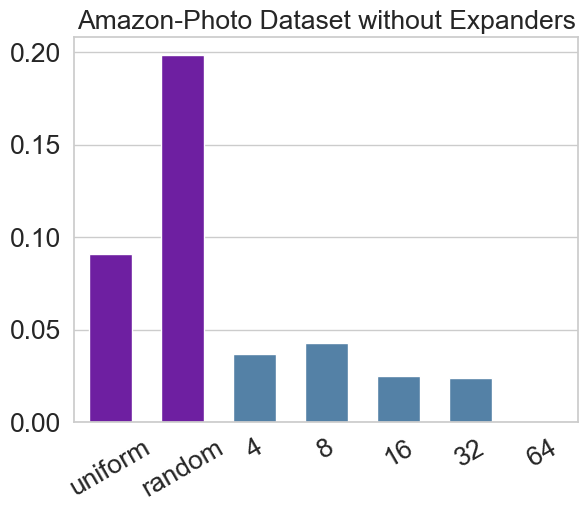

In [76]:
barplot_means(dists_photo, dataset_name = 'Amazon-Photo', exp=False)

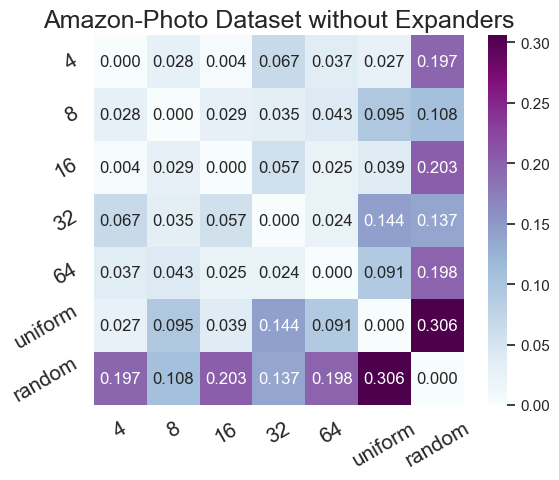

In [77]:
heatmap_plot(dists_photo, dataset_name = 'Amazon-Photo', exp=False, layer=-1)

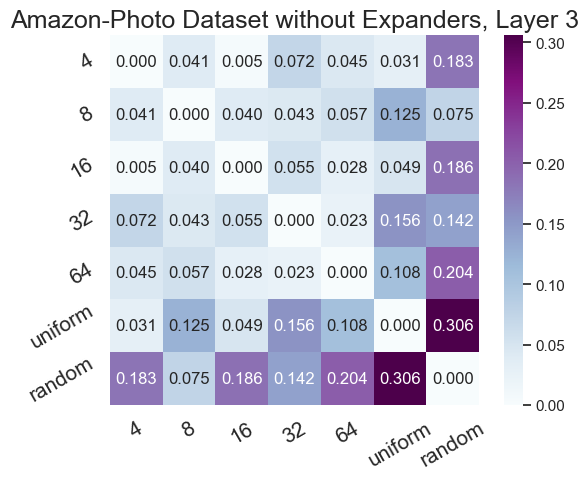

In [78]:
heatmap_plot(dists_photo, dataset_name = 'Amazon-Photo', exp=False, layer=3)

## Photo with expanders

In [79]:
dists_photo_w_exp = calculate_all_pair_dists(scns_photo_w_exp)

0it [00:00, ?it/s]
100%|█████████████████████████████████████████████| 6/6 [01:06<00:00, 11.00s/it]


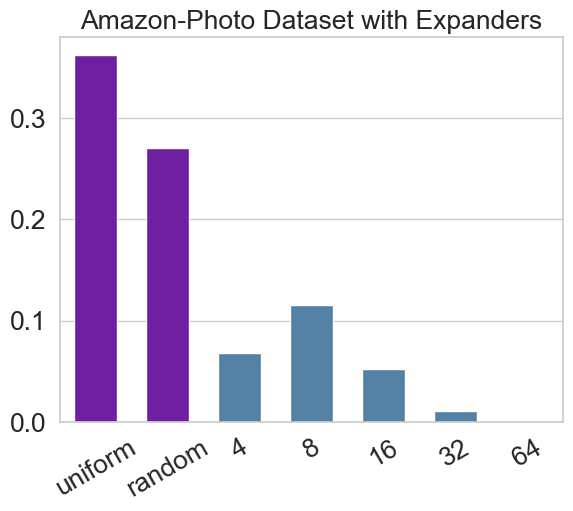

In [80]:
barplot_means(dists_photo_w_exp, dataset_name = 'Amazon-Photo', exp=True)

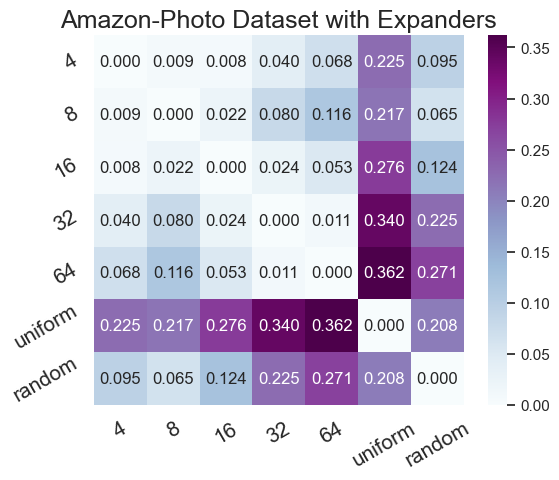

In [81]:
heatmap_plot(dists_photo_w_exp, dataset_name = 'Amazon-Photo', exp=True, layer=-1)

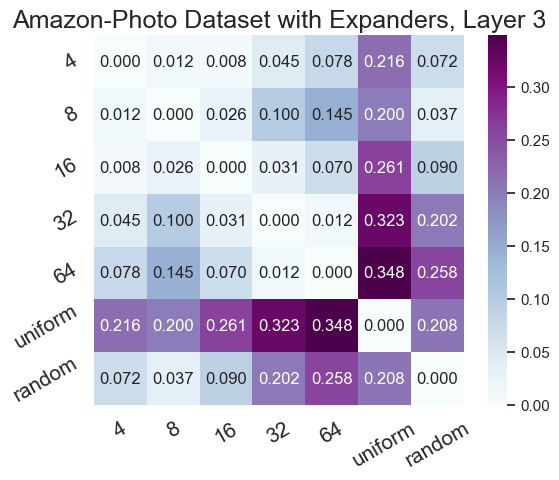

In [82]:
heatmap_plot(dists_photo_w_exp, dataset_name = 'Amazon-Photo', exp=True, layer=3)

## Actor wo expanders

In [83]:
dists_actor_wo_exp = calculate_all_pair_dists(scns_actor_wo_exp)

0it [00:00, ?it/s]
100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.23s/it]


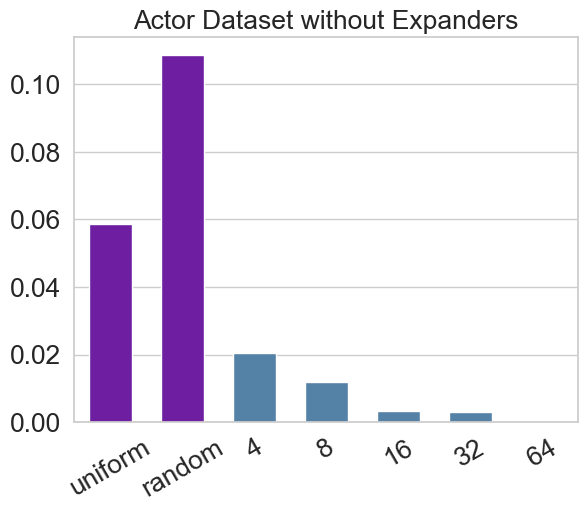

In [84]:
barplot_means(dists_actor_wo_exp, dataset_name = 'Actor', exp=False)

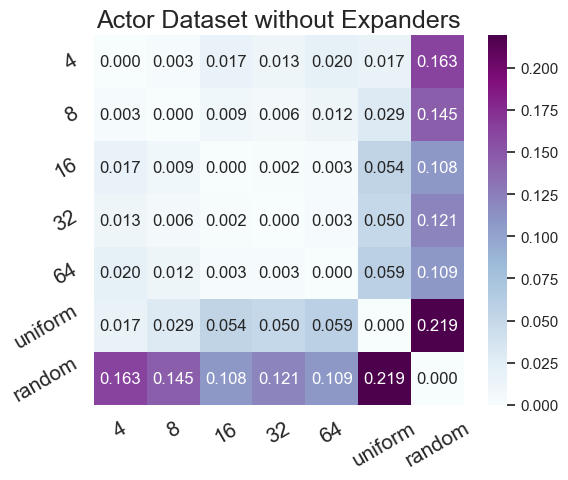

In [85]:
heatmap_plot(dists_actor_wo_exp, dataset_name = 'Actor', exp=False, layer=-1)

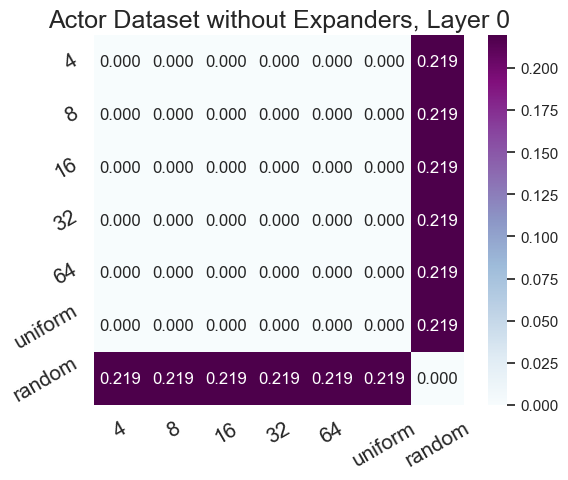

In [86]:
heatmap_plot(dists_actor_wo_exp, dataset_name = 'Actor', exp=False, layer=0)

## Actor with expanders

In [87]:
dists_actor_w_exp = calculate_all_pair_dists(scns_actor_w_exp)

0it [00:00, ?it/s]
100%|█████████████████████████████████████████████| 6/6 [00:22<00:00,  3.68s/it]


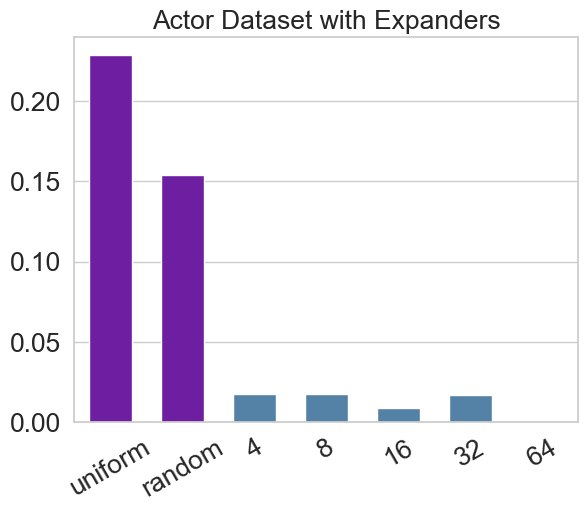

In [88]:
barplot_means(dists_actor_w_exp, dataset_name = 'Actor', exp=True)

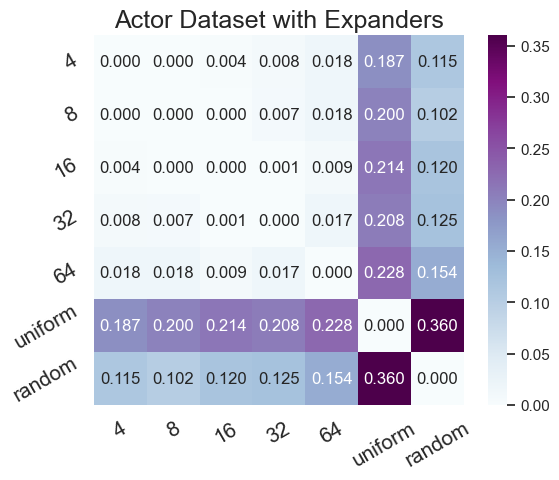

In [89]:
heatmap_plot(dists_actor_w_exp, dataset_name = 'Actor', exp=True, layer=-1)

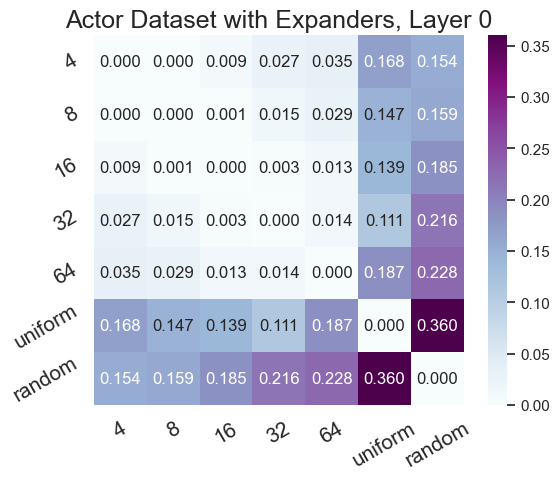

In [90]:
heatmap_plot(dists_actor_w_exp, dataset_name = 'Actor', exp=True, layer=0)

In [110]:
def barplot_means_all(dists_list, dataset_names):
    """
    Plots bar charts for means of distributions as subplots.

    Args:
        dists_list (list): A list of numpy arrays, where each array contains distributions for a dataset.
        dataset_names (list): A list of dataset names corresponding to each distribution in dists_list.
        exp (bool): Whether to include "Expanders" in the title or not.
    """
    # Initialize the figure with 4 subplots
    fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=False)
    
    # Loop over each dataset
    for idx, (dists, dataset_name) in enumerate(zip(dists_list, dataset_names)):
        ax = axes[idx]
        
        # Compute means
        tmp = np.mean(dists, axis=0)
        dist_map = {'uniform': tmp[4, 5], 'random': tmp[4, 6]}
        names = [4, 8, 16, 32, 64]
        for i, name in enumerate(names):
            dist_map[name] = tmp[4, i]
        
        # Bar colors
        cols = ['steelblue' if x > 1 else '#7209B7' for x in range(7)]
        
        # Plot bar chart for the current dataset
        sns.set(style='whitegrid')
        sns.barplot(x=list(dist_map.keys()), y=list(dist_map.values()), palette=cols, dodge=False, width=0.9, ax=ax)
        
        # Formatting
        ax.set_title(f'{dataset_name}', fontsize=28)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30, fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=22)
        
        if idx == 0:
            ax.set_ylabel('Energy Distance to 64', fontsize=25)
    
    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig('Figures/energy_dists_combined.pdf', bbox_inches='tight')
    plt.show()


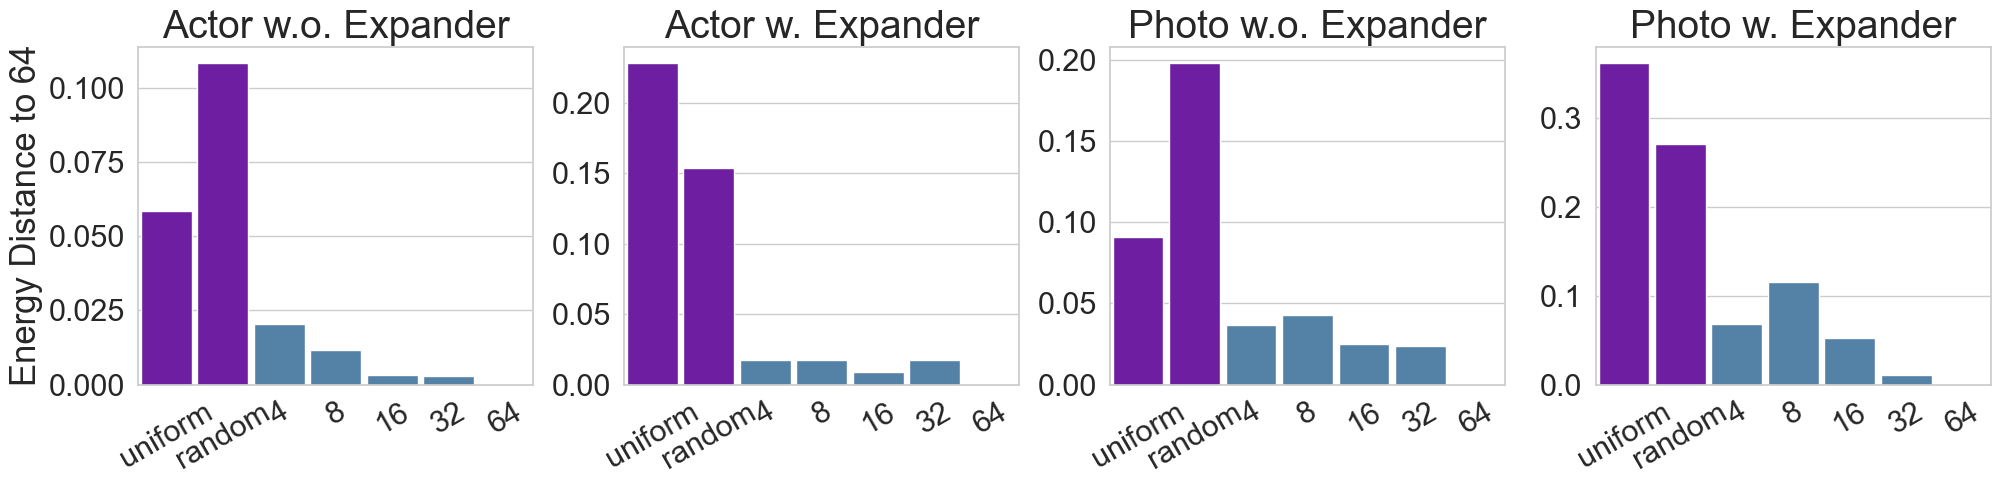

In [111]:
dists_all = [dists_actor_wo_exp, dists_actor_w_exp, dists_photo, dists_photo_w_exp]
dataset_names = ['Actor w.o. Expander', 'Actor w. Expander', 'Photo w.o. Expander', 'Photo w. Expander']
barplot_means_all(dists_all, dataset_names)

# Smoothness Analysis

In [34]:
def norm2_smoothness(x):
    if len(x) == 0:
        return 1.0
    else:
        return np.sum(x**2)/np.sum(x)

def calculate_average_smoothness(scn, smoothness_func=norm2_smoothness):
    smoothness = []
    layer_smoothness = np.zeros(4)
    for i, layer_scores in enumerate(scn):
        smoothness.append([])
        n_avg_smths = []
        for node_scores in layer_scores:
            smoothness[-1].append([])
            for node_sample_score in node_scores:
                smoothness[-1][-1].append(smoothness_func(node_sample_score))
            n_avg_smths.append(np.mean(smoothness[-1][-1]))
        # print(f'average smoothness in layer {i}: {np.mean(n_avg_smths)}')
        layer_smoothness[i] = np.mean(n_avg_smths)

    return layer_smoothness
    

In [42]:
res = calculate_average_smoothness(scns_photo_wo_exp[1], entropy)
print(res)

average smoothness in layer 0: 2.7876410484313965
average smoothness in layer 1: 2.223989963531494
average smoothness in layer 2: 2.214873790740967
average smoothness in layer 3: 2.1884403228759766
[2.78764105 2.22398996 2.21487379 2.18844032]


In [43]:
smth_actor_wo_exp = []
for scn in scns_actor_wo_exp:
    smth_actor_wo_exp.append(calculate_average_smoothness(scn, entropy))
smth_actor_wo_exp = np.stack(smth_actor_wo_exp)

average smoothness in layer 0: 0.7987362742424011
average smoothness in layer 1: 0.7668228149414062
average smoothness in layer 2: 0.7677686810493469
average smoothness in layer 3: 0.7544316053390503
average smoothness in layer 0: 0.7987362742424011
average smoothness in layer 1: 0.7404922842979431
average smoothness in layer 2: 0.7380052208900452
average smoothness in layer 3: 0.7378152012825012
average smoothness in layer 0: 0.7987357974052429
average smoothness in layer 1: 0.6533852219581604
average smoothness in layer 2: 0.6287757158279419
average smoothness in layer 3: 0.6192765831947327
average smoothness in layer 0: 0.7987362146377563
average smoothness in layer 1: 0.6816099286079407
average smoothness in layer 2: 0.6924696564674377
average smoothness in layer 3: 0.681297779083252
average smoothness in layer 0: 0.7987321615219116
average smoothness in layer 1: 0.6086522340774536
average smoothness in layer 2: 0.6186054348945618
average smoothness in layer 3: 0.6237695813179016
a

In [75]:
smth_actor_w_exp = []
for scn in scns_actor_w_exp:
    smth_actor_w_exp.append(calculate_average_smoothness(scn, entropy))
smth_actor_w_exp = np.stack(smth_actor_w_exp)

average smoothness in layer 0: 2.1001086235046387
average smoothness in layer 1: 1.8303585052490234
average smoothness in layer 2: 1.7138618230819702
average smoothness in layer 3: 1.7683416604995728
average smoothness in layer 0: 2.217137098312378
average smoothness in layer 1: 1.7524096965789795
average smoothness in layer 2: 1.785530686378479
average smoothness in layer 3: 1.6583802700042725
average smoothness in layer 0: 2.3109724521636963
average smoothness in layer 1: 1.7494275569915771
average smoothness in layer 2: 1.7092247009277344
average smoothness in layer 3: 1.6579108238220215
average smoothness in layer 0: 2.4638512134552
average smoothness in layer 1: 1.7382835149765015
average smoothness in layer 2: 1.6154141426086426
average smoothness in layer 3: 1.6650806665420532
average smoothness in layer 0: 2.3140151500701904
average smoothness in layer 1: 1.654718279838562
average smoothness in layer 2: 1.674656629562378
average smoothness in layer 3: 1.6145315170288086
average

In [53]:
smth_photo_wo_exp = []
for scn in scns_photo_wo_exp:
    smth_photo_wo_exp.append(calculate_average_smoothness(scn, entropy))
smth_photo_wo_exp = np.stack(smth_photo_wo_exp)

average smoothness in layer 0: 2.817068576812744
average smoothness in layer 1: 2.6684441566467285
average smoothness in layer 2: 2.694962978363037
average smoothness in layer 3: 2.6768434047698975
average smoothness in layer 0: 2.7876410484313965
average smoothness in layer 1: 2.223989963531494
average smoothness in layer 2: 2.214873790740967
average smoothness in layer 3: 2.1884403228759766
average smoothness in layer 0: 2.854942560195923
average smoothness in layer 1: 2.6473944187164307
average smoothness in layer 2: 2.6771371364593506
average smoothness in layer 3: 2.6786320209503174
average smoothness in layer 0: 2.7429022789001465
average smoothness in layer 1: 2.0692367553710938
average smoothness in layer 2: 2.1578381061553955
average smoothness in layer 3: 2.2762203216552734
average smoothness in layer 0: 2.755183219909668
average smoothness in layer 1: 2.5722038745880127
average smoothness in layer 2: 2.6017463207244873
average smoothness in layer 3: 2.615710735321045
average

In [56]:
smth_photo_w_exp = []
for scn in scns_photo_w_exp:
    smth_photo_w_exp.append(calculate_average_smoothness(scn, entropy))
smth_photo_w_exp = np.stack(smth_photo_w_exp)

average smoothness in layer 0: 2.895923137664795
average smoothness in layer 1: 2.565708637237549
average smoothness in layer 2: 2.5963046550750732
average smoothness in layer 3: 2.5488975048065186
average smoothness in layer 0: 2.767399311065674
average smoothness in layer 1: 2.262587308883667
average smoothness in layer 2: 2.3867409229278564
average smoothness in layer 3: 2.360966205596924
average smoothness in layer 0: 2.8817334175109863
average smoothness in layer 1: 2.302562713623047
average smoothness in layer 2: 2.315843343734741
average smoothness in layer 3: 2.3234806060791016
average smoothness in layer 0: 2.908060073852539
average smoothness in layer 1: 2.667543411254883
average smoothness in layer 2: 2.634857654571533
average smoothness in layer 3: 2.680405616760254
average smoothness in layer 0: 2.9023120403289795
average smoothness in layer 1: 2.8556928634643555
average smoothness in layer 2: 2.8790996074676514
average smoothness in layer 3: 2.8854732513427734
average smo

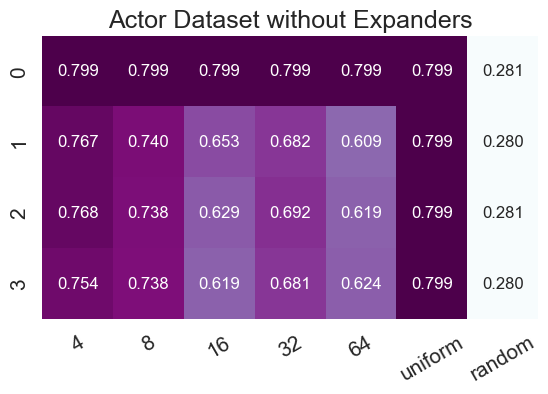

In [76]:
plot_smoothness_heatmap(smth_actor_wo_exp, dataset_name='Actor', exp=False)

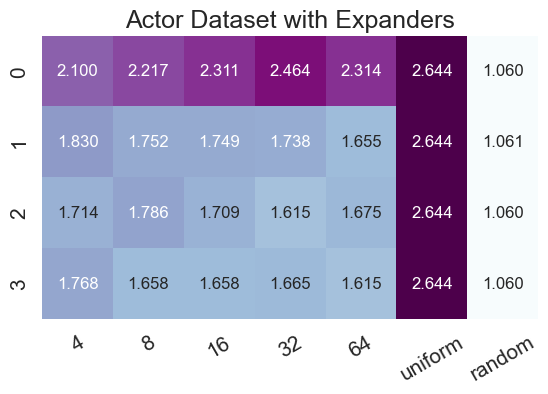

In [77]:
plot_smoothness_heatmap(smth_actor_w_exp, dataset_name='Actor', exp=True)

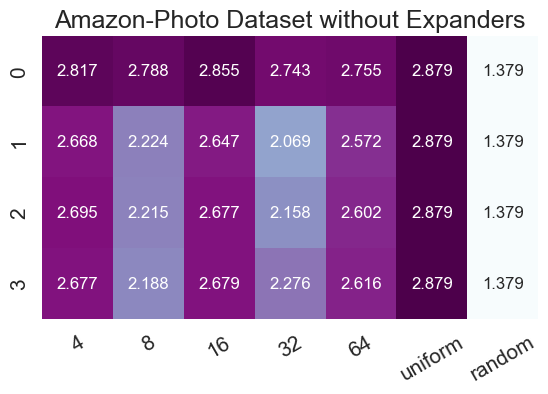

In [78]:
plot_smoothness_heatmap(smth_photo_wo_exp, dataset_name='Amazon-Photo', exp=False)

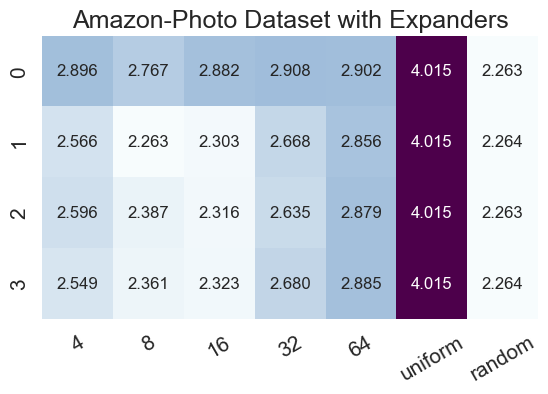

In [79]:
plot_smoothness_heatmap(smth_photo_w_exp, dataset_name='Amazon-Photo', exp=True)

## Distance between the layers

In [69]:
def dists_inter_layer(scns, dist_func = custom_enery_distance):
    all_dists = []
    for i in tqdm(range(5)):
        scn = scns[i]
        n_layers = len(scn)
        dists = np.zeros((n_layers, n_layers))
        for layer1 in range(n_layers):
            for layer2 in range(layer1+1, n_layers):
                layer_dists = []
                for i in range(len(scn[0])):
                    layer_dists.append(dist_func(np.matrix(scn[layer1][i]), np.matrix(scn[layer2][i])))
                # print(f'layers:{layer1}, {layer2} | mean: {np.mean(layer_dists)} | median: {np.median(layer_dists)} | max: {np.max(layer_dists)}, min: {np.min(layer_dists)}')
                dists[layer1][layer2] = np.mean(layer_dists)
                dists[layer2][layer1] = np.mean(layer_dists)
        all_dists.append(dists)
    all_dists = np.stack(all_dists)
    return all_dists

In [70]:
actor_wo_exp_dists = dists_inter_layer(scns_actor_wo_exp)

100%|█████████████████████████████████████████████| 5/5 [00:17<00:00,  3.48s/it]


In [71]:
actor_w_exp_dists = dists_inter_layer(scns_actor_w_exp)

100%|█████████████████████████████████████████████| 5/5 [00:26<00:00,  5.35s/it]


In [72]:
photo_wo_exp_dists = dists_inter_layer(scns_photo_wo_exp)

100%|█████████████████████████████████████████████| 5/5 [00:58<00:00, 11.70s/it]


In [73]:
photo_w_exp_dists = dists_inter_layer(scns_photo_w_exp)

100%|█████████████████████████████████████████████| 5/5 [01:28<00:00, 17.79s/it]


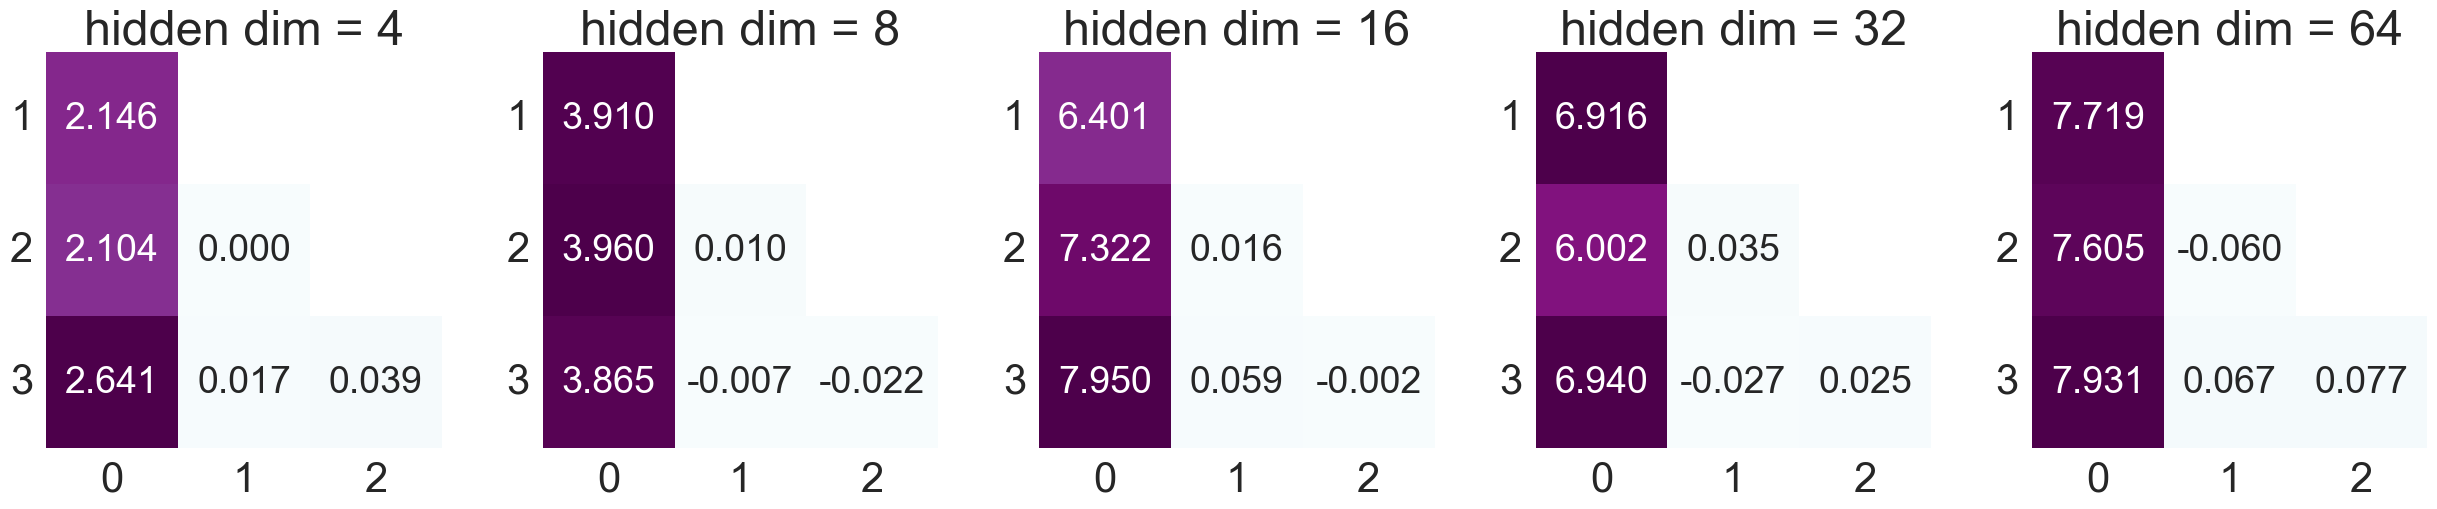

In [92]:
plot_inter_layer_similarity(actor_wo_exp_dists, 'Actor', exp=False)

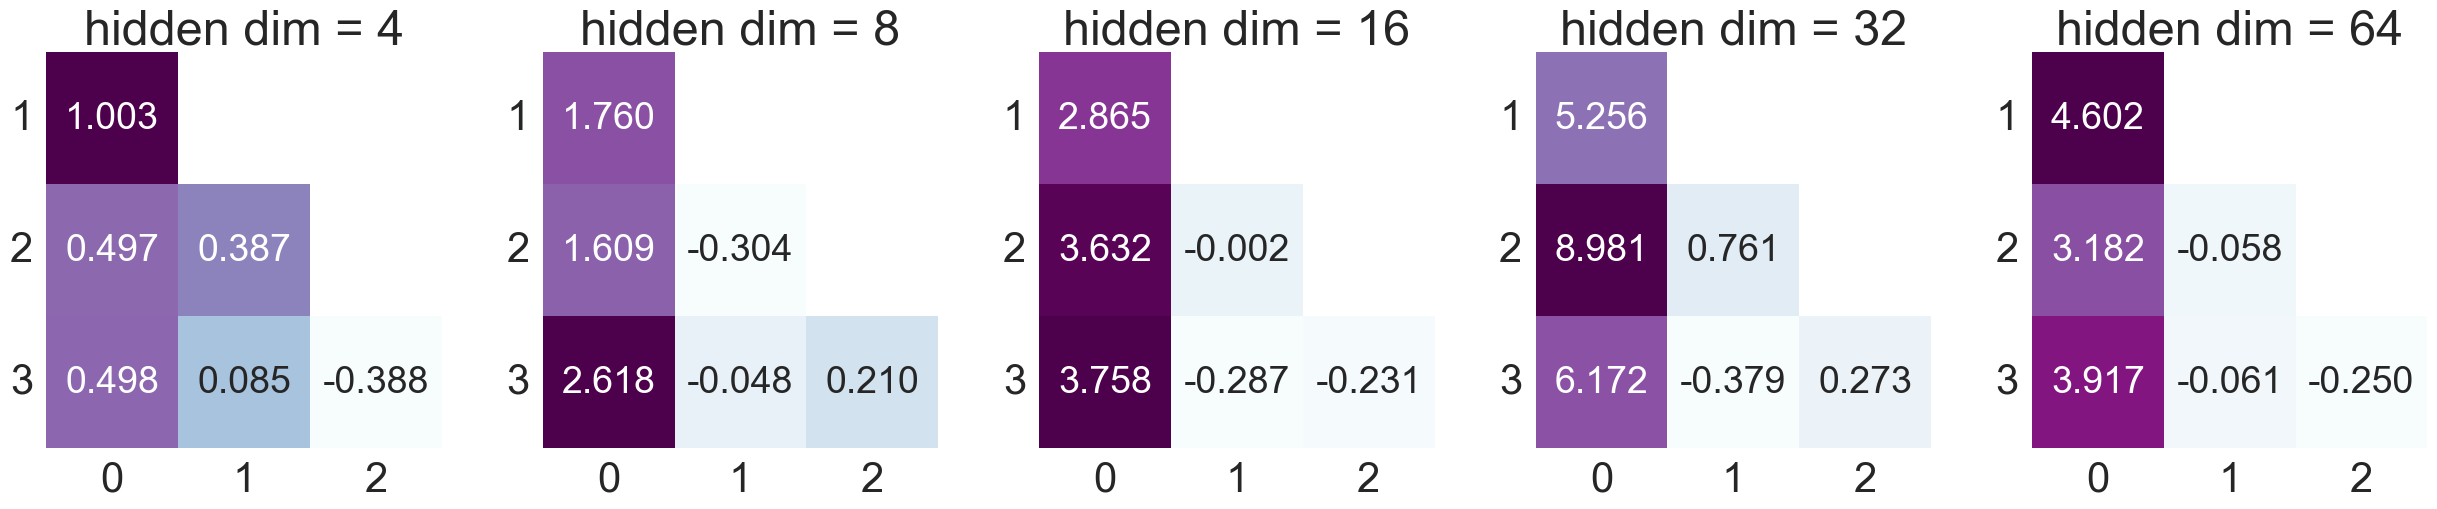

In [93]:
plot_inter_layer_similarity(actor_w_exp_dists, 'Actor', exp=True)

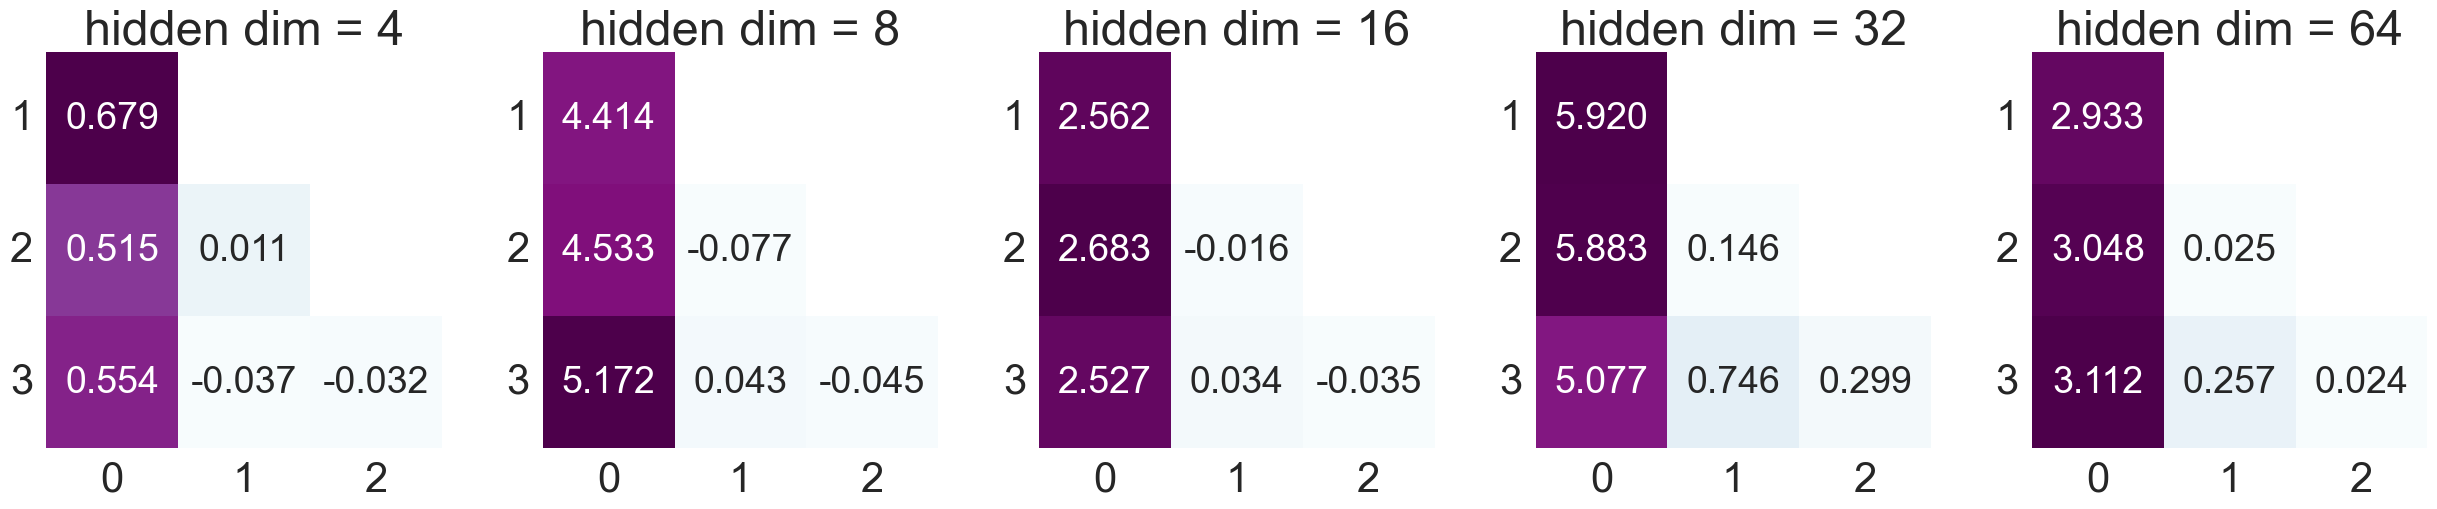

In [94]:
plot_inter_layer_similarity(photo_wo_exp_dists, 'Amazon-Photo', exp=False)

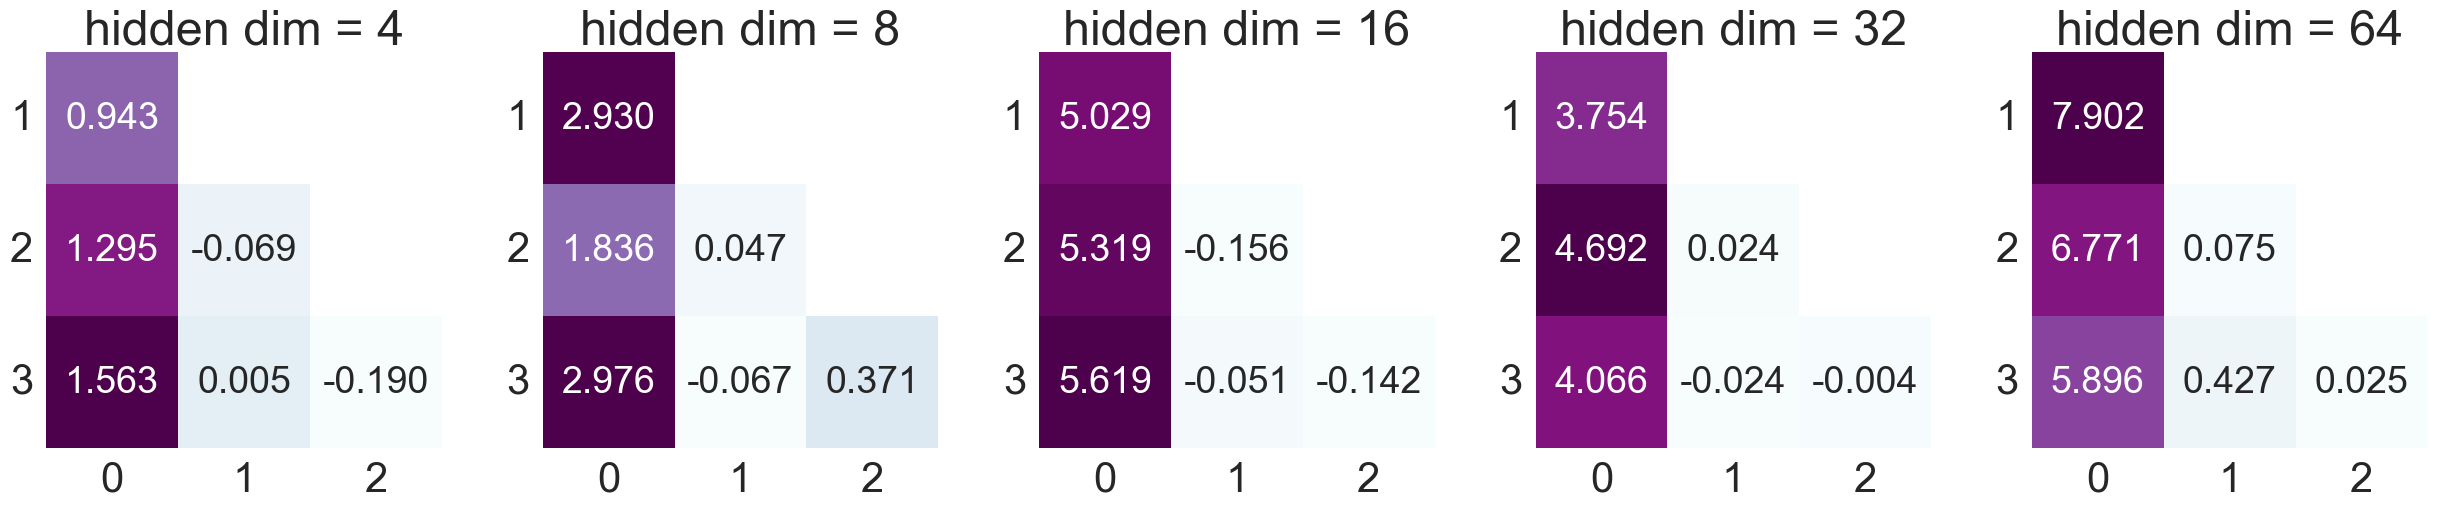

In [95]:
plot_inter_layer_similarity(photo_w_exp_dists, 'Amazon-Photo', exp=True)

## PRDC

In [519]:
metrics_actor_wo_exp = []
tmp_scns = scns_actor_wo_exp
for i, scn in enumerate(tmp_scns):
    if i == 4:
        continue
    metrics_actor_wo_exp.append(find_prdc(tmp_scns[i], tmp_scns[4]))

precision: layer:0 | mean: 0.6285961968680089 | median: 0.96 | max: 0.98, min: 0.0
recall: layer:0 | mean: 0.4080238627889634 | median: 0.51 | max: 0.97, min: 0.0
density: layer:0 | mean: 0.6772203579418345 | median: 0.784 | max: 1.9300000000000002, min: 0.0
coverage: layer:0 | mean: 0.28173750932140196 | median: 0.39 | max: 0.68, min: 0.0
precision: layer:1 | mean: 0.6483426547352722 | median: 0.98 | max: 1.0, min: 0.0
recall: layer:1 | mean: 0.4683855331841909 | median: 0.5 | max: 1.0, min: 0.0
density: layer:1 | mean: 1.0717762863534674 | median: 0.8960000000000001 | max: 6.514, min: 0.0
coverage: layer:1 | mean: 0.4710850111856824 | median: 0.66 | max: 0.98, min: 0.0
precision: layer:2 | mean: 0.6465287099179716 | median: 0.98 | max: 1.0, min: 0.0
recall: layer:2 | mean: 0.4820469798657718 | median: 0.53 | max: 1.0, min: 0.0
density: layer:2 | mean: 1.0990835197613722 | median: 0.916 | max: 6.866, min: 0.0
coverage: layer:2 | mean: 0.4858202833706189 | median: 0.68 | max: 0.99, min

In [520]:
metrics_actor_w_exp = []
tmp_scns = scns_actor_w_exp
for i, scn in enumerate(tmp_scns):
    if i == 4:
        continue
    metrics_actor_w_exp.append(find_prdc(tmp_scns[i], tmp_scns[4]))

precision: layer:0 | mean: 0.9818065789473686 | median: 0.99 | max: 1.0, min: 0.92
recall: layer:0 | mean: 0.9476723684210527 | median: 0.96 | max: 0.97, min: 0.88
density: layer:0 | mean: 1.0027255263157895 | median: 1.0 | max: 1.128, min: 0.8740000000000001
coverage: layer:0 | mean: 0.9366802631578945 | median: 0.94 | max: 0.99, min: 0.84
precision: layer:1 | mean: 0.9147407894736842 | median: 0.92 | max: 1.0, min: 0.71
recall: layer:1 | mean: 0.8755565789473684 | median: 0.88 | max: 1.0, min: 0.51
density: layer:1 | mean: 1.1332094736842104 | median: 1.1039999999999999 | max: 2.8160000000000003, min: 0.7080000000000001
coverage: layer:1 | mean: 0.935075 | median: 0.94 | max: 1.0, min: 0.73
precision: layer:2 | mean: 0.9319644736842105 | median: 0.94 | max: 1.0, min: 0.76
recall: layer:2 | mean: 0.8594368421052632 | median: 0.87 | max: 1.0, min: 0.41
density: layer:2 | mean: 1.1817857894736843 | median: 1.1720000000000002 | max: 1.958, min: 0.8720000000000001
coverage: layer:2 | mean

In [521]:
metrics_photo_wo_exp = []
tmp_scns = scns_photo_wo_exp
for i, scn in enumerate(tmp_scns):
    if i == 4:
        continue
    metrics_photo_wo_exp.append(find_prdc(tmp_scns[i], tmp_scns[4]))

precision: layer:0 | mean: 0.6486171201061712 | median: 0.65 | max: 1.0, min: 0.0
recall: layer:0 | mean: 0.7910258792302588 | median: 0.81 | max: 1.0, min: 0.0
density: layer:0 | mean: 0.7307899137358992 | median: 0.6940000000000001 | max: 1.972, min: 0.0
coverage: layer:0 | mean: 0.5827564698075647 | median: 0.6 | max: 1.0, min: 0.0
precision: layer:1 | mean: 0.7516045122760452 | median: 0.77 | max: 1.0, min: 0.0
recall: layer:1 | mean: 0.8082627737226278 | median: 0.86 | max: 1.0, min: 0.0
density: layer:1 | mean: 0.9594540145985403 | median: 0.876 | max: 4.564, min: 0.0
coverage: layer:1 | mean: 0.5141619110816191 | median: 0.5 | max: 0.98, min: 0.0
precision: layer:2 | mean: 0.7251559389515593 | median: 0.75 | max: 1.0, min: 0.0
recall: layer:2 | mean: 0.7502481751824819 | median: 0.8 | max: 1.0, min: 0.0
density: layer:2 | mean: 0.806277903118779 | median: 0.762 | max: 3.132, min: 0.0
coverage: layer:2 | mean: 0.46234240212342403 | median: 0.46 | max: 0.92, min: 0.0
precision: la

In [522]:
metrics_photo_w_exp = []
tmp_scns = scns_photo_w_exp
for i, scn in enumerate(tmp_scns):
    if i == 4:
        continue
    metrics_photo_w_exp.append(find_prdc(tmp_scns[i], tmp_scns[4]))

precision: layer:0 | mean: 0.3985411764705882 | median: 0.39 | max: 0.76, min: 0.14
recall: layer:0 | mean: 0.971291503267974 | median: 0.98 | max: 1.0, min: 0.51
density: layer:0 | mean: 0.23876287581699346 | median: 0.22599999999999998 | max: 0.536, min: 0.05600000000000001
coverage: layer:0 | mean: 0.23120392156862746 | median: 0.22 | max: 0.82, min: 0.08
precision: layer:1 | mean: 0.46290718954248367 | median: 0.42 | max: 0.99, min: 0.12
recall: layer:1 | mean: 0.9096692810457516 | median: 0.94 | max: 1.0, min: 0.22
density: layer:1 | mean: 0.3290975163398693 | median: 0.282 | max: 1.344, min: 0.03
coverage: layer:1 | mean: 0.4080522875816993 | median: 0.4 | max: 0.93, min: 0.06
precision: layer:2 | mean: 0.36918039215686277 | median: 0.32 | max: 1.0, min: 0.04
recall: layer:2 | mean: 0.9242980392156863 | median: 0.95 | max: 1.0, min: 0.34
density: layer:2 | mean: 0.2803288888888889 | median: 0.244 | max: 1.4380000000000002, min: 0.014000000000000002
coverage: layer:2 | mean: 0.381

In [534]:
len(metrics_photo_w_exp[0]['precision'])

4

In [525]:
import pickle

def save_list_of_dicts(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

def load_list_of_dicts(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

data = [metrics_actor_wo_exp, metrics_actor_w_exp, metrics_photo_wo_exp, metrics_photo_w_exp]
save_list_of_dicts(data, 'prdc_results.pkl')

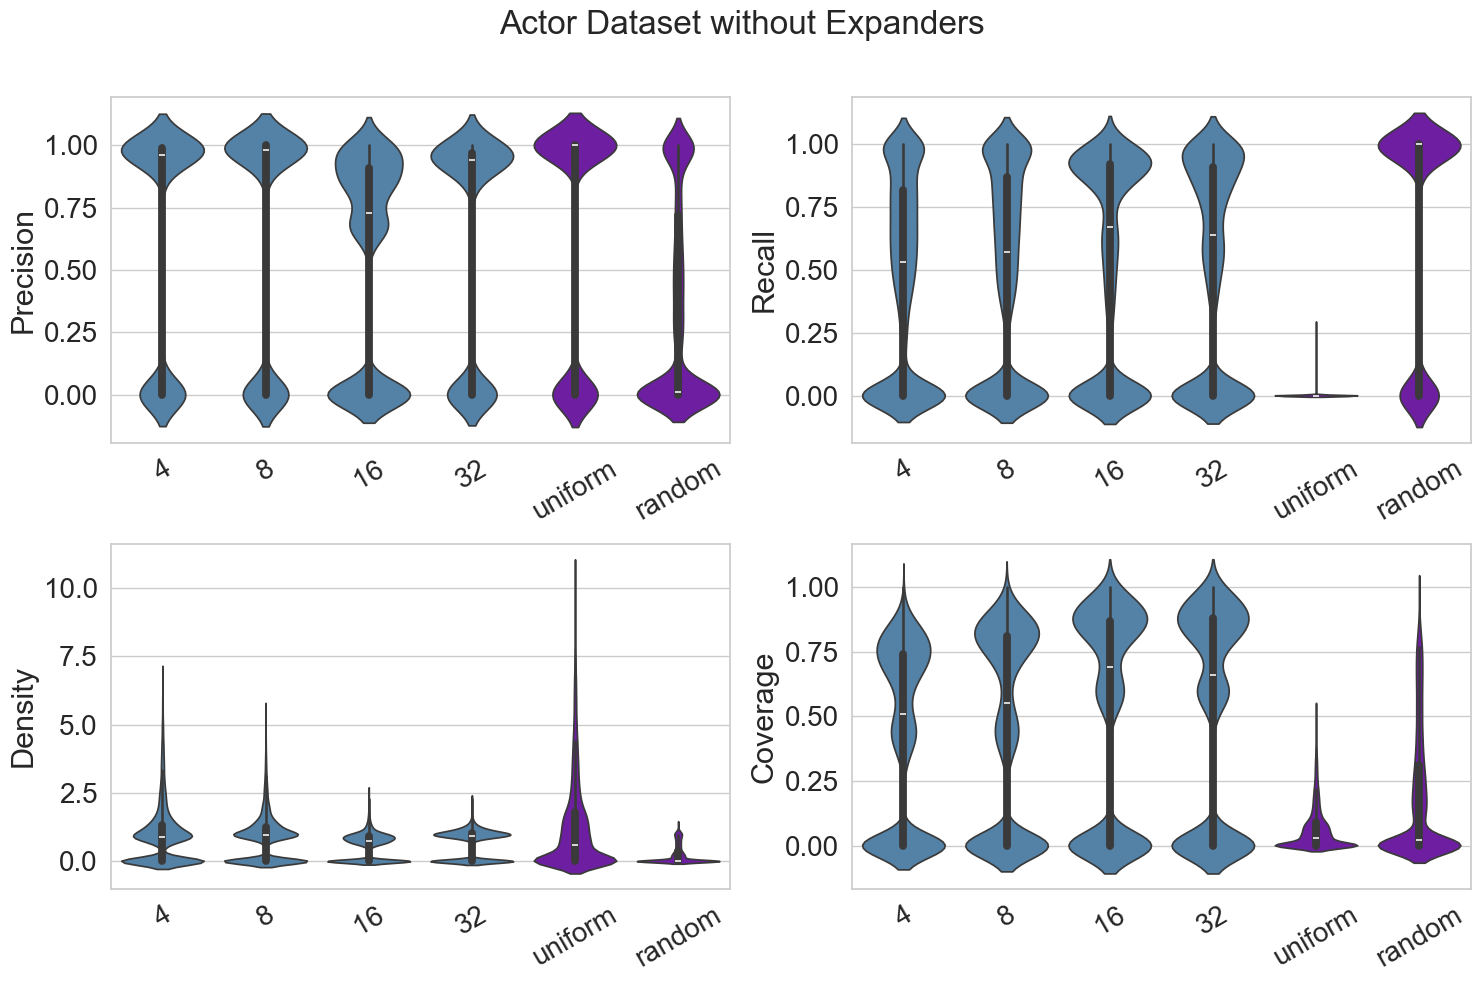

In [608]:
violinplot_prdc(metrics_actor_wo_exp, 'Actor', exp=False)

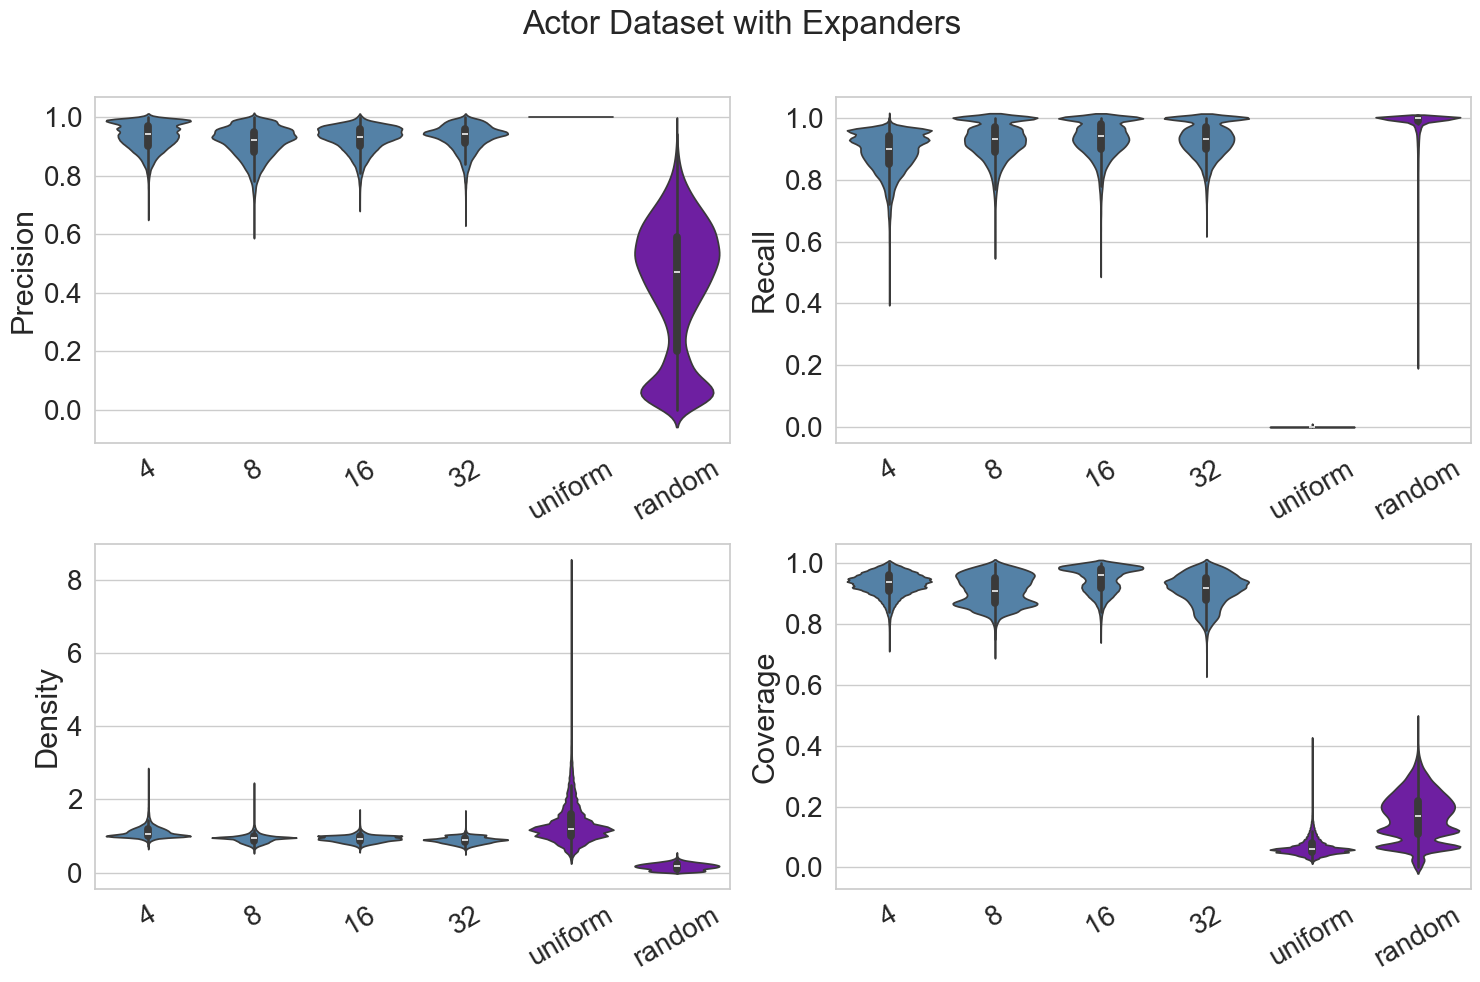

In [609]:
violinplot_prdc(metrics_actor_w_exp, 'Actor', exp=True)

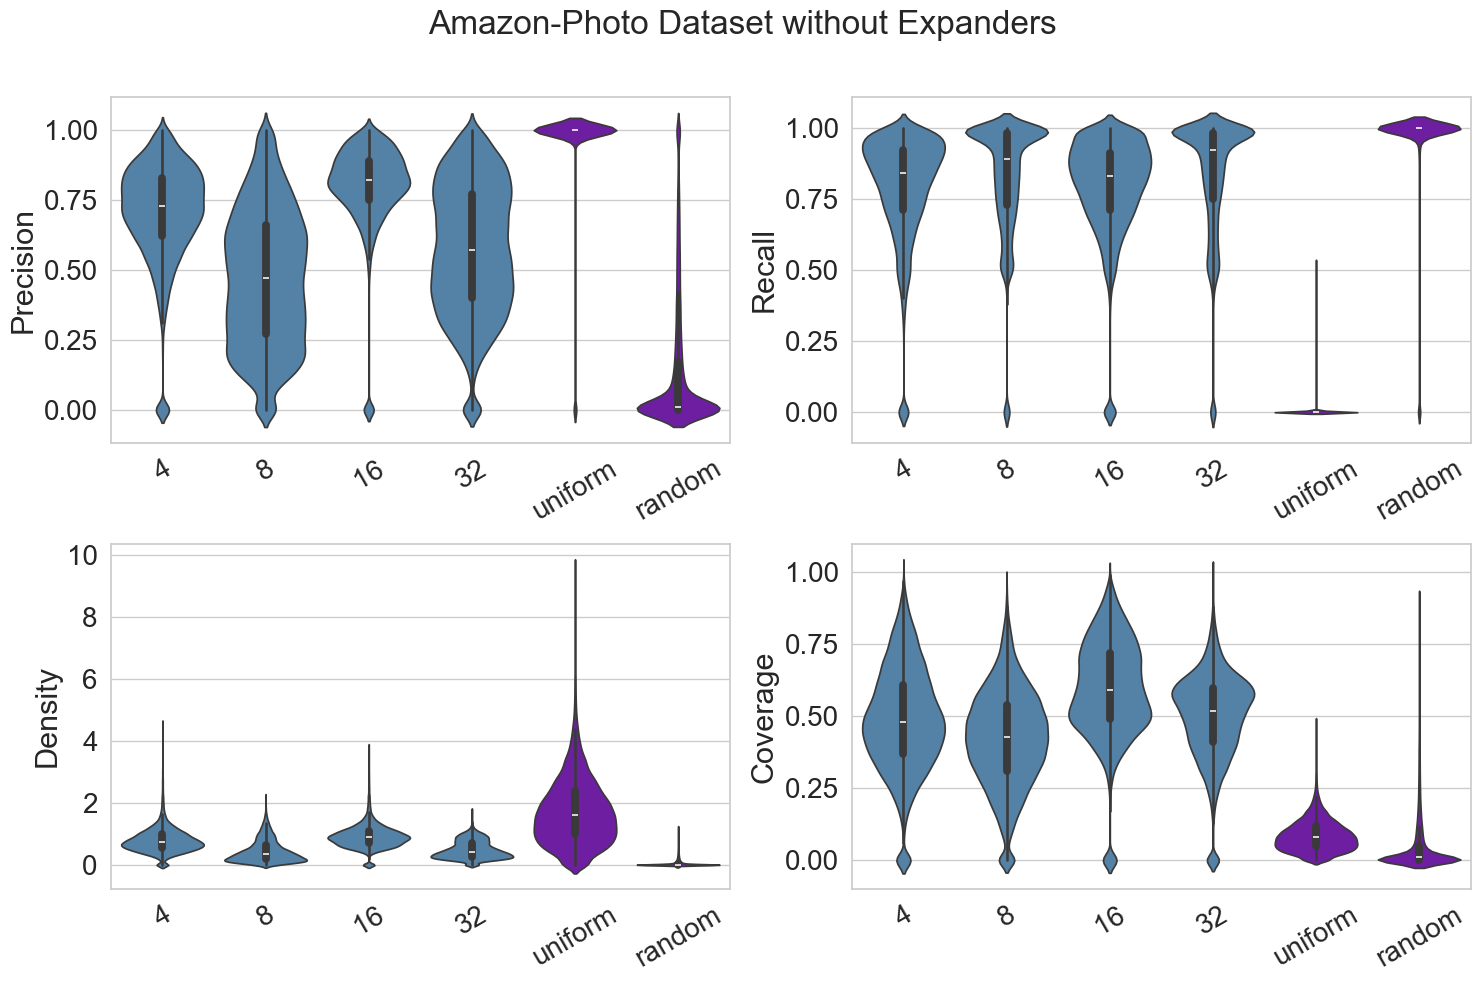

In [610]:
violinplot_prdc(metrics_photo_wo_exp, 'Amazon-Photo', exp=False)

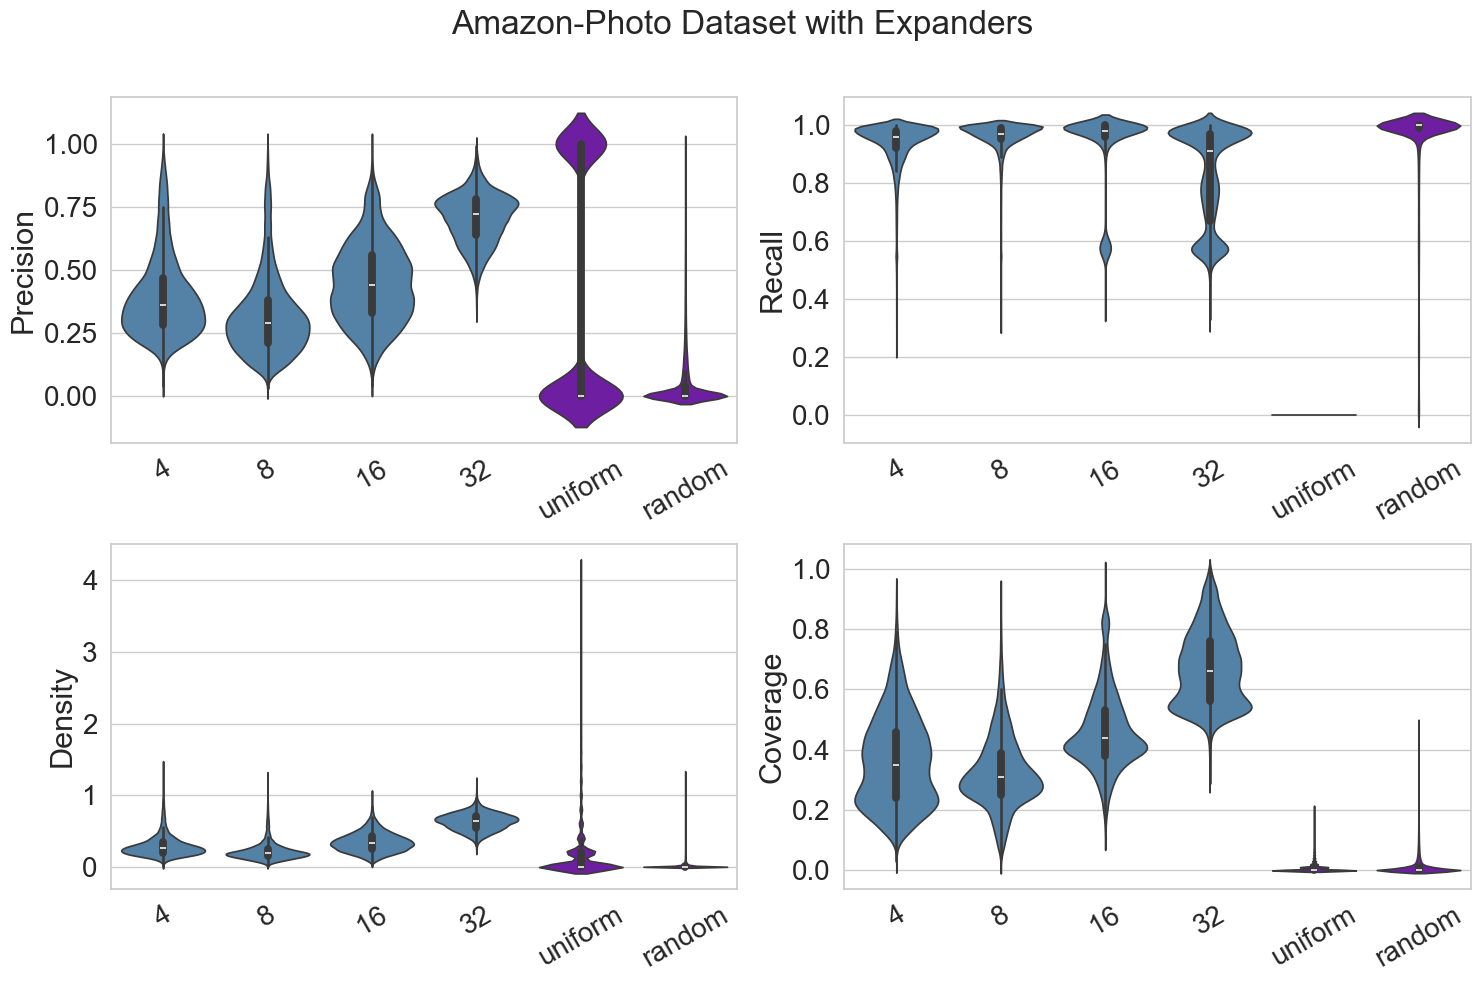

In [611]:
violinplot_prdc(metrics_photo_w_exp, 'Amazon-Photo', exp=True)

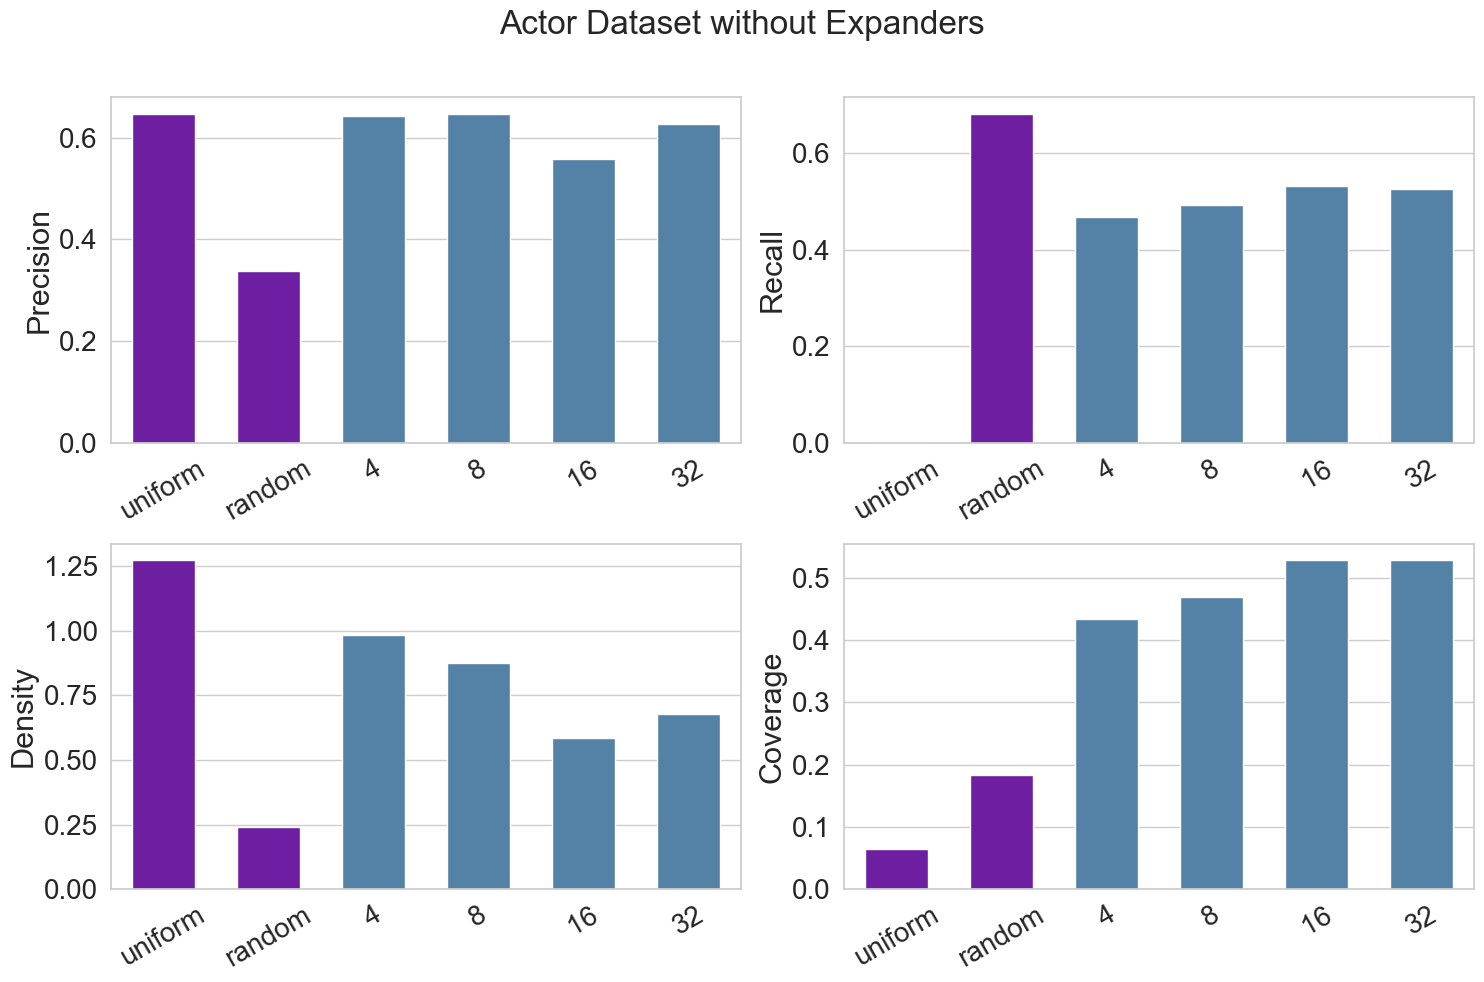

In [614]:
barplot_prdc(metrics_actor_wo_exp, 'Actor', exp=False)

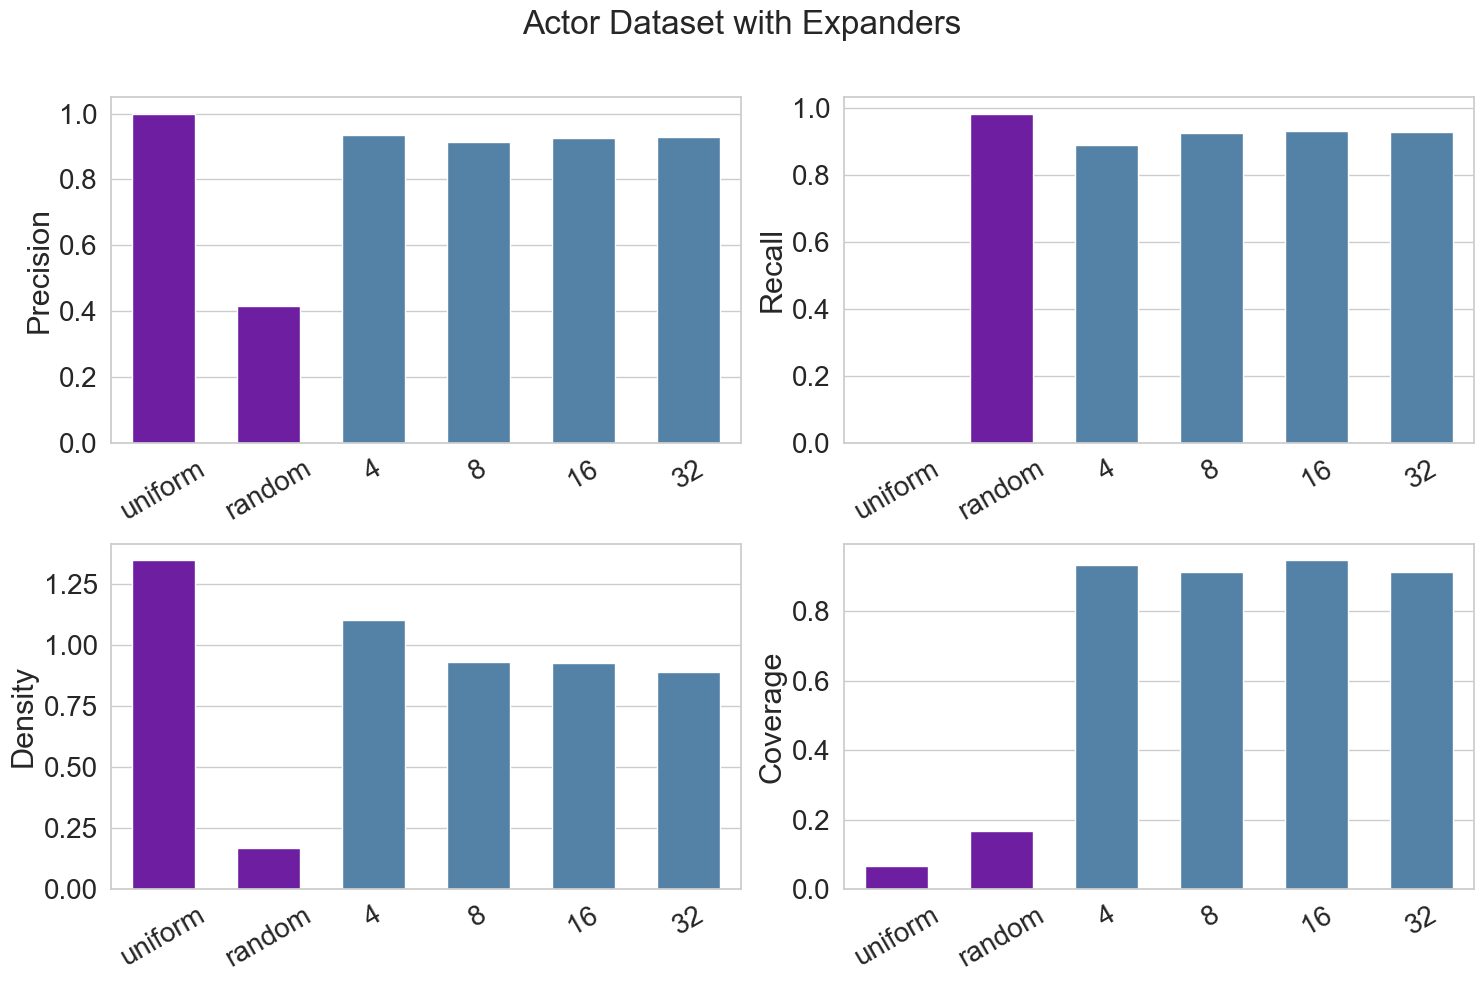

In [615]:
barplot_prdc(metrics_actor_w_exp, 'Actor', exp=True)

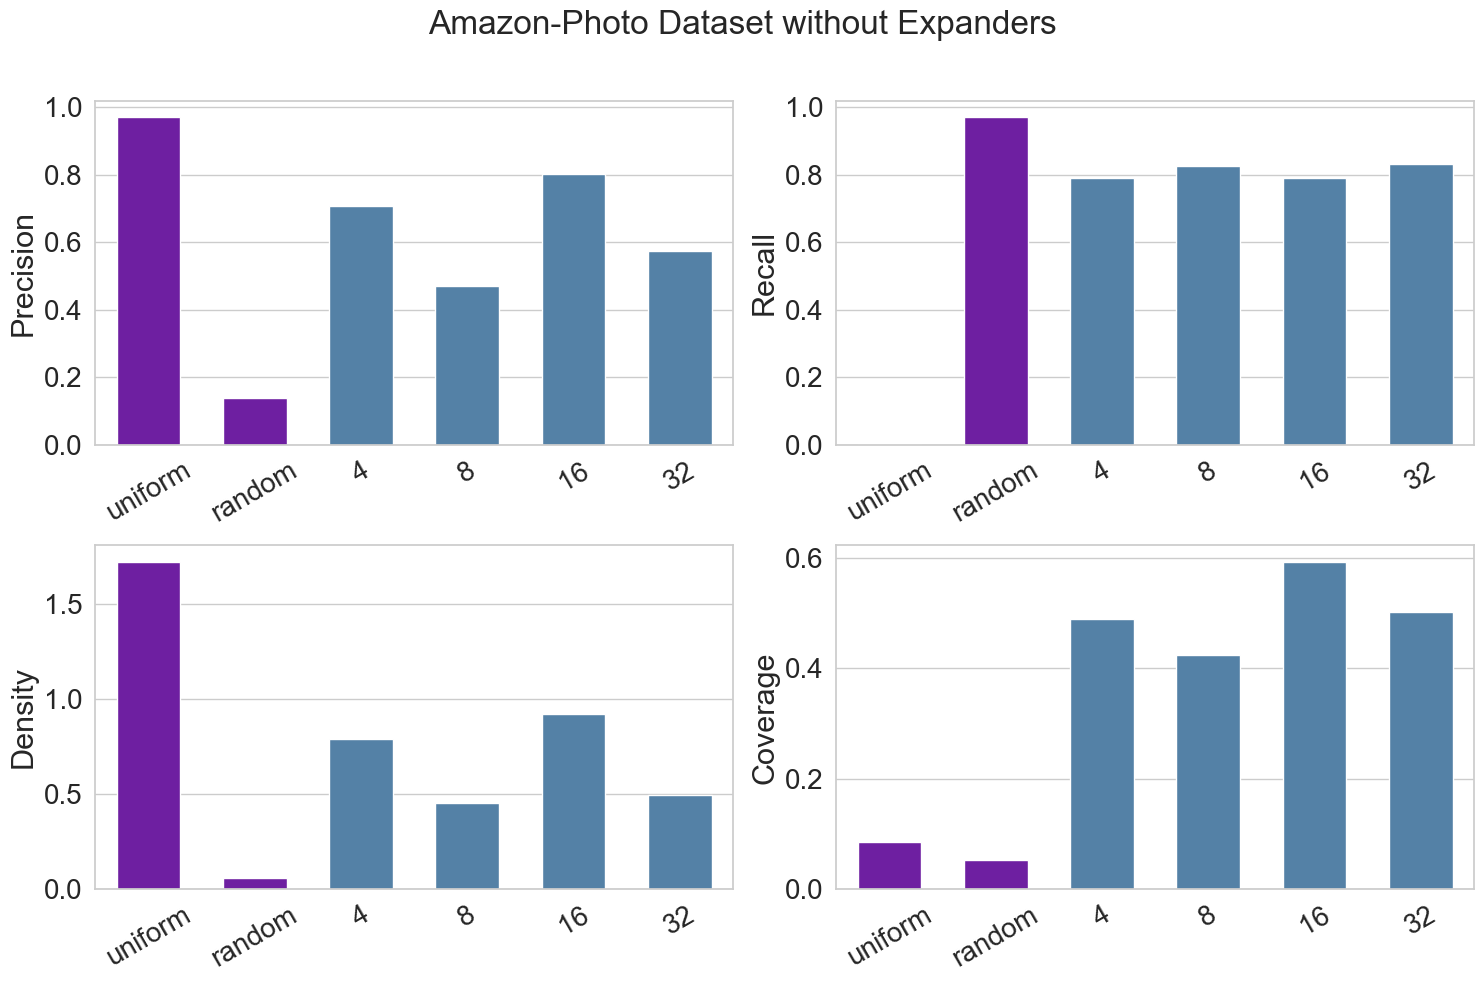

In [616]:
barplot_prdc(metrics_photo_wo_exp, 'Amazon-Photo', exp=False)

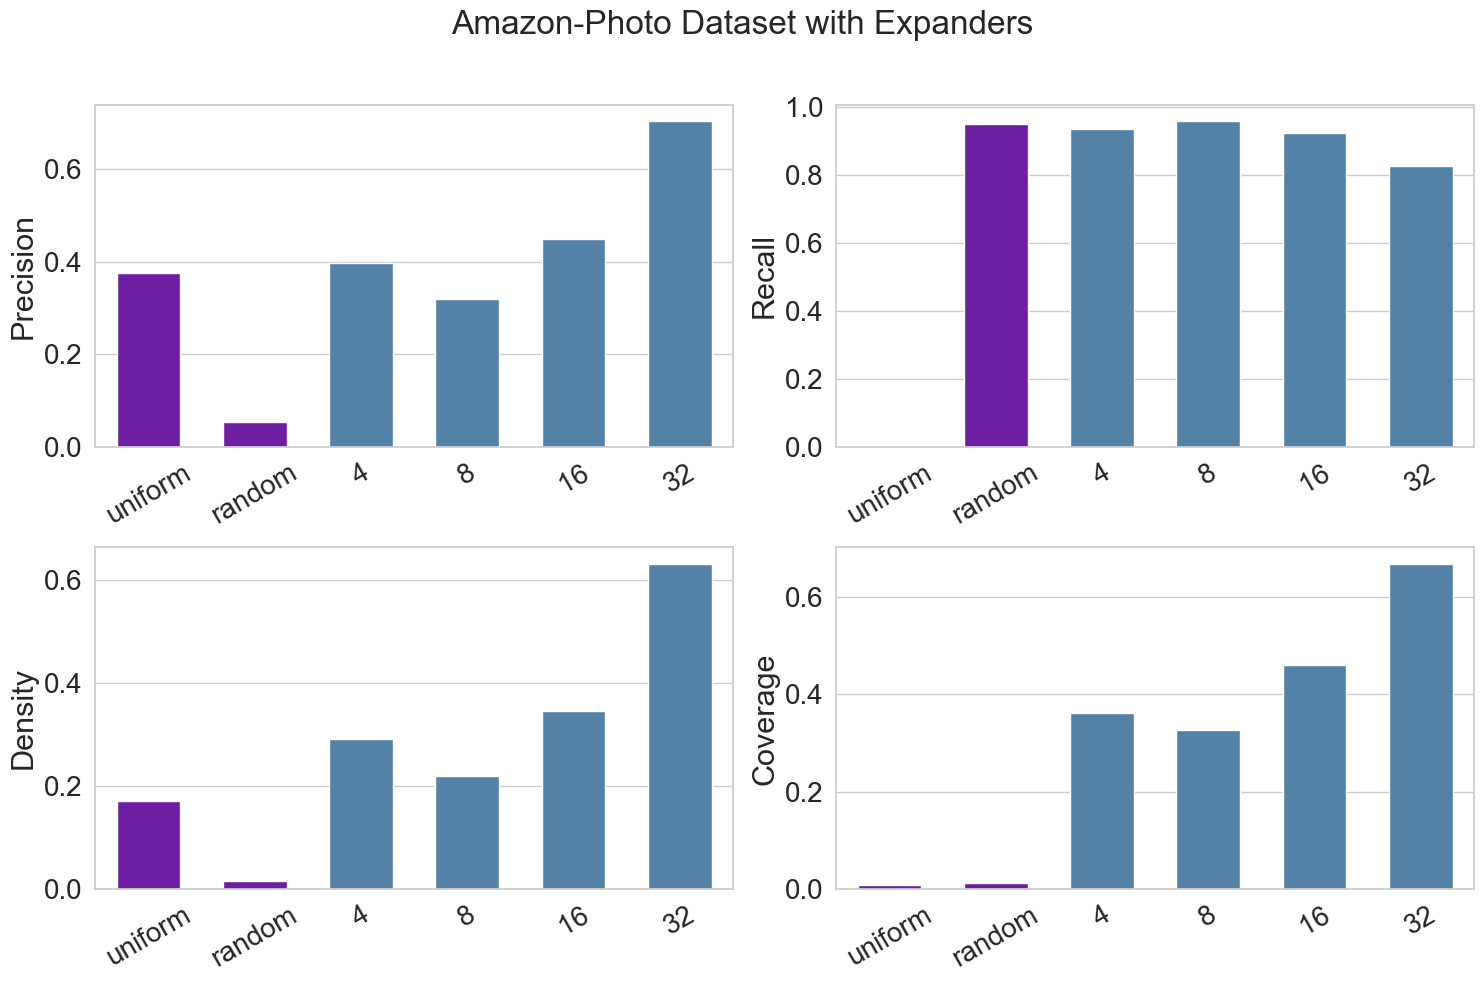

In [617]:
barplot_prdc(metrics_photo_w_exp, 'Amazon-Photo', exp=True)

In [266]:
find_prdc(tmp_scns[0], tmp_scns[4])
find_prdc(tmp_scns[6], tmp_scns[4]);

precision: layer:0 | mean: 0.3985411764705882 | median: 0.39 | max: 0.76, min: 0.14
recall: layer:0 | mean: 0.971291503267974 | median: 0.98 | max: 1.0, min: 0.51
density: layer:0 | mean: 0.23876287581699346 | median: 0.22599999999999998 | max: 0.536, min: 0.05600000000000001
coverage: layer:0 | mean: 0.23120392156862746 | median: 0.22 | max: 0.82, min: 0.08
precision: layer:1 | mean: 0.46290718954248367 | median: 0.42 | max: 0.99, min: 0.12
recall: layer:1 | mean: 0.9096692810457516 | median: 0.94 | max: 1.0, min: 0.22
density: layer:1 | mean: 0.3290975163398693 | median: 0.282 | max: 1.344, min: 0.03
coverage: layer:1 | mean: 0.4080522875816993 | median: 0.4 | max: 0.93, min: 0.06
precision: layer:2 | mean: 0.36918039215686277 | median: 0.32 | max: 1.0, min: 0.04
recall: layer:2 | mean: 0.9242980392156863 | median: 0.95 | max: 1.0, min: 0.34
density: layer:2 | mean: 0.2803288888888889 | median: 0.244 | max: 1.4380000000000002, min: 0.014000000000000002
coverage: layer:2 | mean: 0.381

{'precision': [[0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.03,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.01,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.01,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.01,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.01,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.01,
   0.0,
   0.02,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.01,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   

In [269]:
find_prdc(tmp_scns[5], tmp_scns[4]);

precision: layer:0 | mean: 0.013464052287581699 | median: 0.0 | max: 1.0, min: 0.0
recall: layer:0 | mean: 0.0 | median: 0.0 | max: 0.0, min: 0.0
density: layer:0 | mean: 0.004784313725490197 | median: 0.0 | max: 0.8, min: 0.0
coverage: layer:0 | mean: 0.0002392156862745098 | median: 0.0 | max: 0.04, min: 0.0
precision: layer:1 | mean: 0.8826143790849673 | median: 1.0 | max: 1.0, min: 0.0
recall: layer:1 | mean: 0.0 | median: 0.0 | max: 0.0, min: 0.0
density: layer:1 | mean: 0.33163398692810464 | median: 0.2 | max: 4.2, min: 0.0
coverage: layer:1 | mean: 0.01658169934640523 | median: 0.01 | max: 0.21, min: 0.0
precision: layer:2 | mean: 0.3115032679738562 | median: 0.0 | max: 1.0, min: 0.0
recall: layer:2 | mean: 0.0 | median: 0.0 | max: 0.0, min: 0.0
density: layer:2 | mean: 0.1618562091503268 | median: 0.0 | max: 3.8000000000000003, min: 0.0
coverage: layer:2 | mean: 0.00809281045751634 | median: 0.0 | max: 0.19, min: 0.0
precision: layer:3 | mean: 0.2942483660130719 | median: 0.0 | 

## Topk-attention

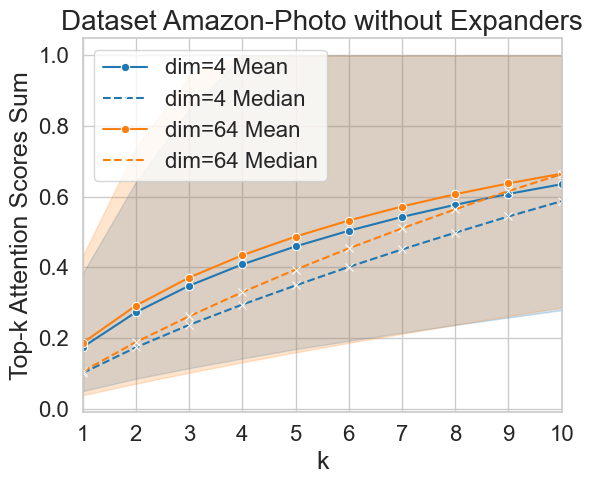

In [23]:
scns_tmp = scns_photo_wo_exp

data_dict_photo_wo_exp = {}
data_dict_photo_wo_exp['dim=4'] = find_attention_topk_cumsums(scns_tmp[0]).mean(axis=2).mean(axis=0).T
data_dict_photo_wo_exp['dim=64'] = find_attention_topk_cumsums(scns_tmp[4]).mean(axis=2).mean(axis=0).T
plot_cumsum(data_dict_photo_wo_exp, 'Amazon-Photo', False)

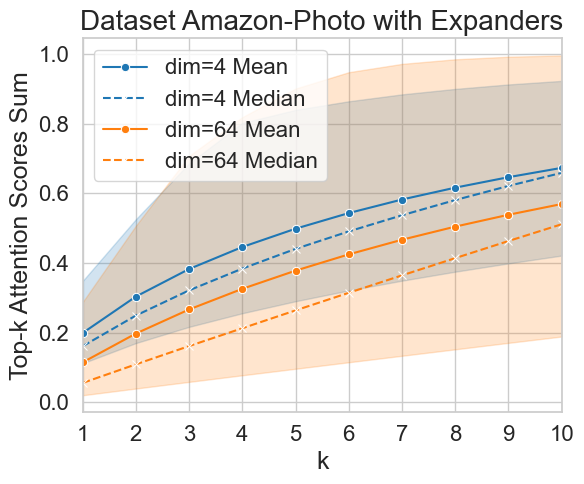

In [24]:
scns_tmp = scns_photo_w_exp

data_dict_photo_w_exp = {}
data_dict_photo_w_exp['dim=4'] = find_attention_topk_cumsums(scns_tmp[0]).mean(axis=2).mean(axis=0).T
data_dict_photo_w_exp['dim=64'] = find_attention_topk_cumsums(scns_tmp[4]).mean(axis=2).mean(axis=0).T
plot_cumsum(data_dict_photo_w_exp, 'Amazon-Photo', True)

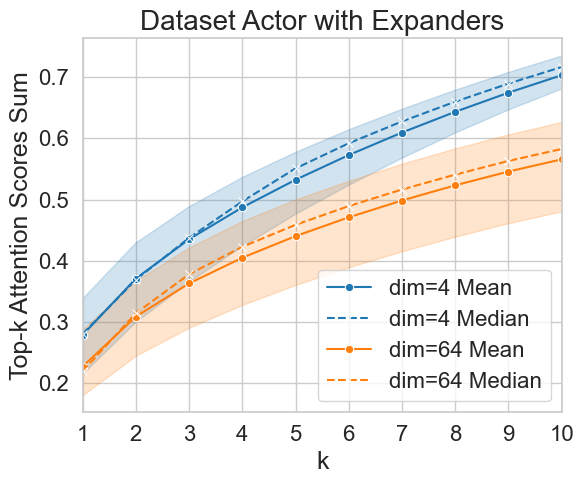

In [25]:
scns_tmp = scns_actor_w_exp

data_dict_actor_w_exp = {}
data_dict_actor_w_exp['dim=4'] = find_attention_topk_cumsums(scns_tmp[0]).mean(axis=2).mean(axis=0).T
data_dict_actor_w_exp['dim=64'] = find_attention_topk_cumsums(scns_tmp[4]).mean(axis=2).mean(axis=0).T
plot_cumsum(data_dict_actor_w_exp, 'Actor', True)

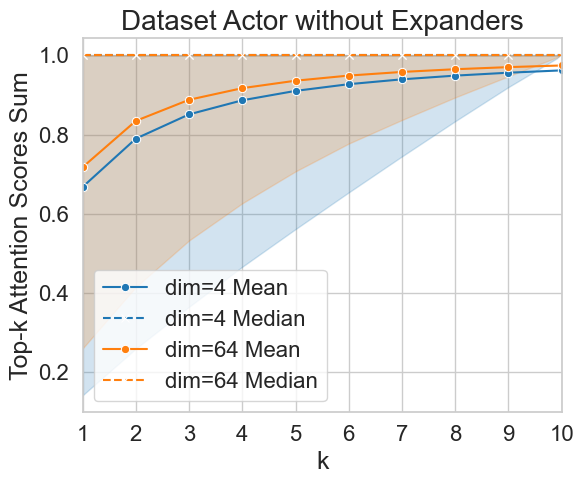

In [27]:
scns_tmp = scns_actor_wo_exp

data_dict_actor_wo_exp = {}
data_dict_actor_wo_exp['dim=4'] = find_attention_topk_cumsums(scns_tmp[0]).mean(axis=2).mean(axis=0).T
data_dict_actor_wo_exp['dim=64'] = find_attention_topk_cumsums(scns_tmp[4]).mean(axis=2).mean(axis=0).T
plot_cumsum(data_dict_actor_wo_exp, 'Actor', False)

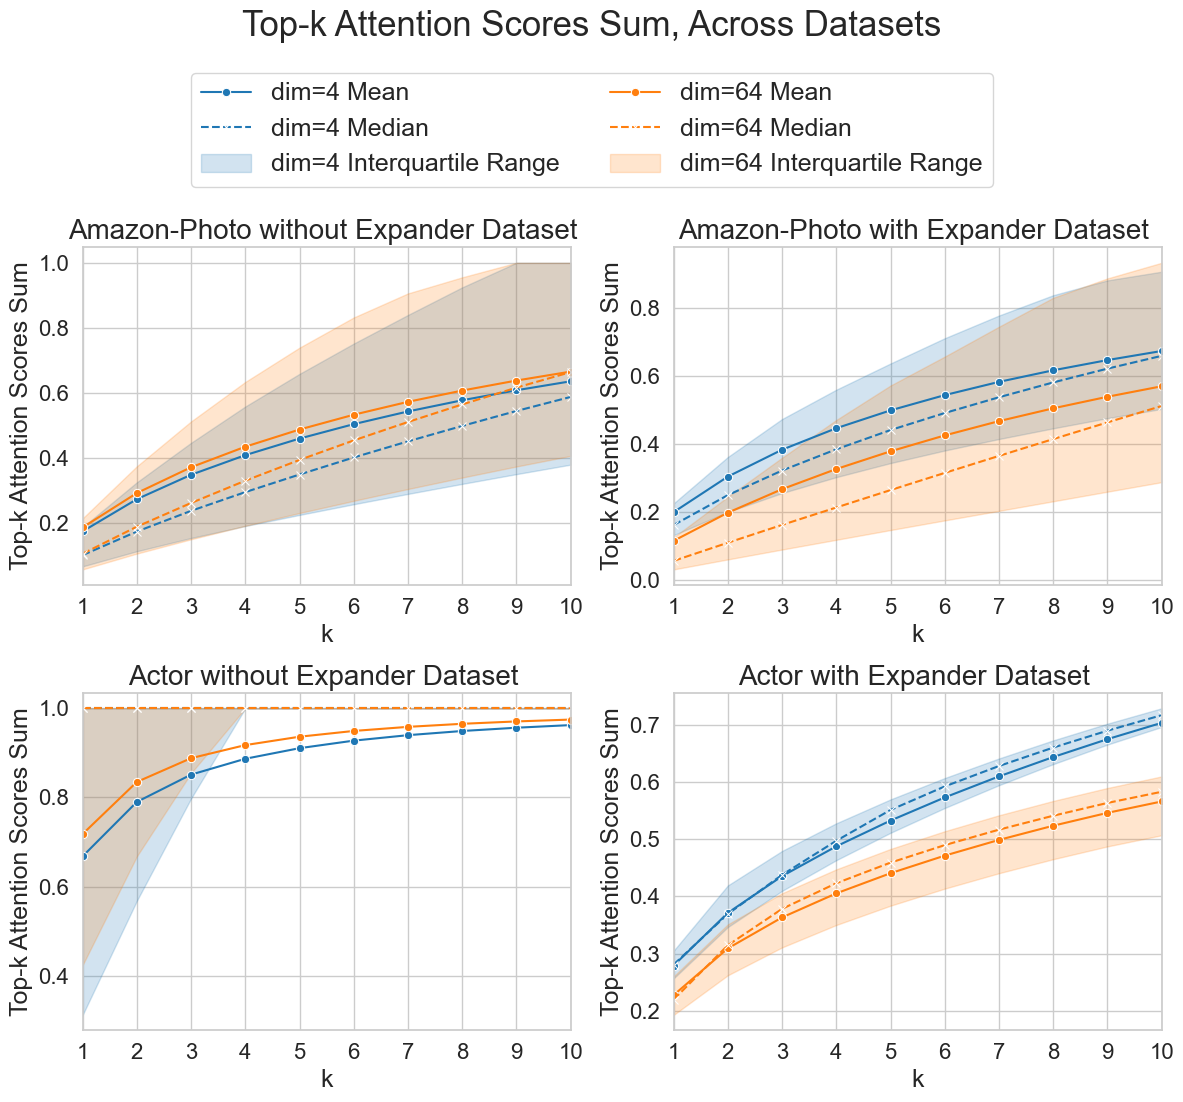

In [28]:
data_dicts = [data_dict_photo_wo_exp, data_dict_photo_w_exp, data_dict_actor_wo_exp, data_dict_actor_w_exp]
dataset_names = ['Amazon-Photo without Expander', 'Amazon-Photo with Expander', 'Actor without Expander', 'Actor with Expander']
plot_cumsum_combined(data_dicts, dataset_names)

In [114]:
def plot_cumsum_combined2(data_dicts, dataset_names, exp=False):
    """
    Plots the given data with standard deviation for each entry in the dictionary using seaborn.

    Args:
        data_dicts (list): A list of dictionaries where keys are names and values are numpy arrays of shape (10, n).
        dataset_names (list): A list of dataset names corresponding to each data_dict.
    """
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    sns.set(style="whitegrid")
    colors = ['#1f77b4', '#ff7f0e']
    plt.rc('axes', titlesize=20)     # Title font size
    plt.rc('axes', labelsize=22)     # X and Y label font size
    plt.rc('xtick', labelsize=22)    # X tick label font size
    plt.rc('ytick', labelsize=18)    # Y tick label font size
    plt.rc('legend', fontsize=18)    # Legend font size

    for idx, (data_dict, dataset_name) in enumerate(zip(data_dicts, dataset_names)):
        ax = axes[idx]
        for i, (name, data) in enumerate(data_dict.items()):
            mean = np.mean(data, axis=1)
            median = np.median(data, axis=1)
            q1 = np.quantile(data, q=0.25, axis=1)
            q2 = np.quantile(data, q=0.75, axis=1)

            x = np.arange(1, 11)
            sns.lineplot(x=x, y=mean, marker='o', label=f'{name} Mean', color=colors[i], ax=ax)
            sns.lineplot(x=x, y=median, marker='x', linestyle='--', label=f'{name} Median', color=colors[i], ax=ax)
            ax.fill_between(x, q1, q2, alpha=0.2, color=colors[i], label=f'{name} Interquartile Range')

        ax.set_xlabel('k')
        if idx == 0:
            ax.set_ylabel('Top-k Attention Scores Sum')
        ax.set_title(f'{dataset_name} ')
        ax.set_xticks(np.arange(1, 11))
        ax.set_xlim(1, 10)
        ax.legend().remove()

    # fig.suptitle(f'Top-k Attention Scores Sum, Across Datasets', y=1.1, fontsize=25)
    handles, labels = ax.get_legend_handles_labels()
    # handles = [handles[0], handles[3], handles[1], handles[4], handles[2], handles[5]]
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=6, frameon=False)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f'Figures/topk_combined_poster.pdf', bbox_inches='tight')
    plt.show()

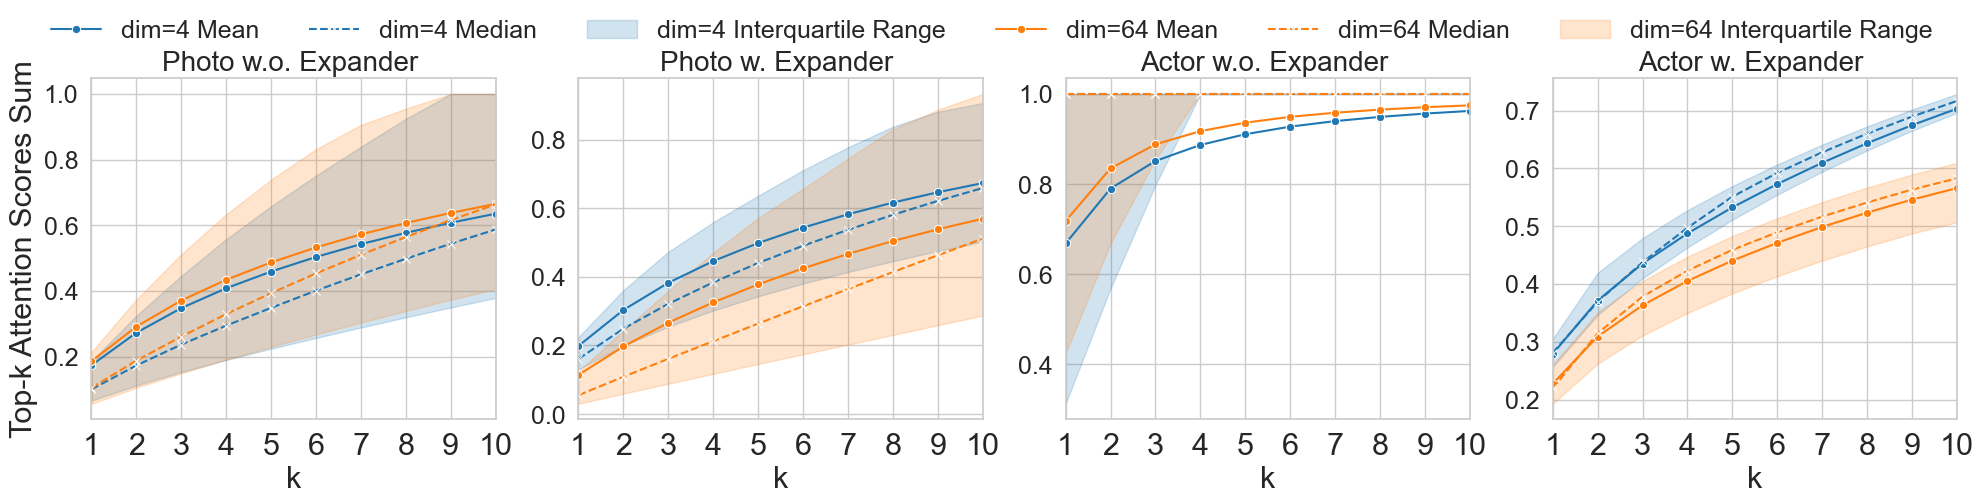

In [115]:
data_dicts = [data_dict_photo_wo_exp, data_dict_photo_w_exp, data_dict_actor_wo_exp, data_dict_actor_w_exp]
dataset_names = ['Photo w.o. Expander', 'Photo w. Expander', 'Actor w.o. Expander', 'Actor w. Expander']
plot_cumsum_combined2(data_dicts, dataset_names)

## High Attention Edge Type

In [456]:
edge_attr = np.load(f'{path_to_scores}/photo_4layer_exp/edge_attr_exp.npy')

In [457]:
scores4 = read_scores('photo_4layer_exp', 4, range(100), 4)

In [638]:
def scores_by_edge_type(all_scores, edge_attr, split_indices=None):
    sum_gedges = 0.0
    sum_exp = 0.0
    sum_self = 0.0
    if split_indices is None:
        split_indices = [bisect.bisect_left(edge_attr, 1), bisect.bisect_left(edge_attr, 2)]
    t1 = split_indices[0]
    t2 = split_indices[1] - split_indices[0]
    t3 = len(edge_attr) - split_indices[1]
    for layer in range(4):
        for seed in range(100):
            scores = all_scores[layer][seed]
            sum_gedges += np.sum(scores[:split_indices[0]])
            sum_exp += np.sum(scores[split_indices[0]:split_indices[1]])
            sum_self += np.sum(scores[split_indices[1]:])
    # print(sum_gedges, sum_exp, sum_self)
    n = 400 * t3
    # print(sum_gedges/n, sum_exp/n, sum_self/n)
    # print(sum_gedges/(indices[0]*400), sum_exp/((indices[1]-indices[0])*400), sum_self/(7650*400))
    
    results = {'sum_ratio': np.array([sum_gedges/n, sum_exp/n, sum_self/n]),
               'normalized': (1/400) * np.array([sum_gedges/t1, sum_exp/t2, sum_self/t3])}
    return results

In [637]:
scores_by_edge_type(scores4, edge_attr)

2118123.623303283 783968.3302614449 157908.2021691214
0.6921972625174128 0.2561988007390343 0.051603987636967774
0.022234063613247316 0.008539997235951408 0.051603987636967774


{'sum_ratio': array([0.69219726, 0.2561988 , 0.05160399]),
 'normalized': array([0.02223406, 0.00853996, 0.05160399])}

In [656]:
name = 'photo_4layer_exp'
photo_edge_attr = np.load(f'{path_to_scores}/{name}/edge_attr_exp.npy')
photo_scores = [read_scores(name, 4, range(100), 4),
                read_scores(name, 8, range(100), 4),
                read_scores(name, 16, range(100), 4),
                read_scores(name, 32, range(100), 4),
                read_scores(name, 64, range(100), 4)]

In [657]:
name = 'actor_4layer_exp'
actor_edge_attr = np.load(f'{path_to_scores}/{name}/edge_attr.npy')
actor_scores = [read_scores(name, 4, range(100), 4),
                read_scores(name, 8, range(100), 4),
                read_scores(name, 16, range(100), 4),
                read_scores(name, 32, range(100), 4),
                read_scores(name, 64, range(100), 4)]

In [659]:
scores_by_edge_type(photo_scores[0], photo_edge_attr)

{'sum_ratio': array([0.69219726, 0.2561988 , 0.05160399]),
 'normalized': array([0.02223406, 0.00853996, 0.05160399])}

In [660]:
photo_sum_ratio = []
photo_normalized = []
for scores in photo_scores:
    res = scores_by_edge_type(scores, photo_edge_attr)
    photo_sum_ratio.append(res['sum_ratio'])
    photo_normalized.append(res['normalized'])

In [661]:
actor_sum_ratio = []
actor_normalized = []
for scores in actor_scores:
    res = scores_by_edge_type(scores, actor_edge_attr)
    actor_sum_ratio.append(res['sum_ratio'])
    actor_normalized.append(res['normalized'])

In [662]:
photo_sum_ratio

[array([0.69219726, 0.2561988 , 0.05160399]),
 array([0.5848639 , 0.32360687, 0.09152927]),
 array([0.74574732, 0.22126212, 0.0318233 ]),
 array([0.90061703, 0.08951263, 0.0098705 ]),
 array([0.93114982, 0.06354457, 0.00530576])]

In [851]:
    def plot_ratios(data_list1, data_list2):
        """
        Plots the ratios of three values in each numpy array in the given lists as stacked bars using different patterns.
        Two plots are shown side by side with a shared legend.

        Args:
            data_list1 (list): A list of numpy arrays, each containing three values that sum to 1 for the first plot.
            data_list2 (list): A list of numpy arrays, each containing three values that sum to 1 for the second plot.
        """
        ratios1 = np.array(data_list1)
        ratios2 = np.array(data_list2)
        x = ['4', '8', '16', '32', '64']
        colors = ['#729fcf', '#ad7fa8', '#d3d7cf']

        fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
        sns.set(style="whitegrid")

        labels = ['Graph Edges', 'Expander Edges', 'Self-loops']
        patterns = ['//', '.', 'x']

        for ax, ratios, title in zip(axes, [ratios1, ratios2], ['Amazon-Photo Dataset', 'Actor Dataset']):
            bottom = np.zeros(len(ratios))
            for i in range(ratios.shape[1]):
                bars = ax.bar(x, ratios[:, i], bottom=bottom, label=labels[i], color=colors[i])
                for bar in bars:
                    bar.set_hatch(patterns[i])
                bottom += ratios[:, i]
            ax.set_xlabel('Hidden Dimension', fontsize=20)
            ax.set_title(title, fontsize=25)
            ax.set_xticks(range(len(x)))
            ax.set_xticklabels(x, fontsize=18)
            ax.tick_params(axis='y', labelsize=18)

        axes[0].set_ylabel('Ratio', fontsize=20)
        axes[0].set_ylim(0, 1)

        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, fontsize=20, loc="upper center",bbox_to_anchor=(0.5, 1.02), ncol=3, frameon=False)

        fig.suptitle('Ratio of Attention Scores by Edge Type', y=1.10, fontsize=25)
        plt.tight_layout(rect=[0, 0, 0.9, 1])
        plt.savefig(f'Figures/edge_type_sum.pdf', bbox_inches='tight')
        plt.show()

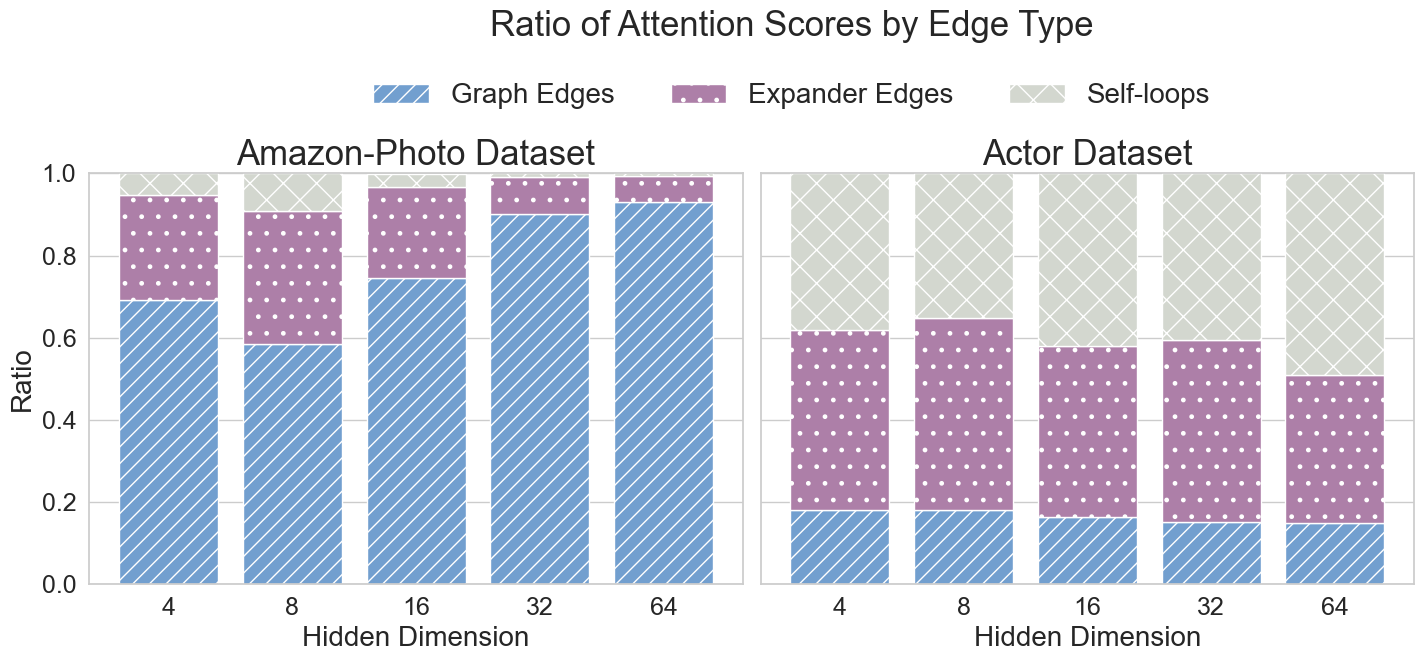

In [852]:
plot_ratios(photo_sum_ratio, actor_sum_ratio)

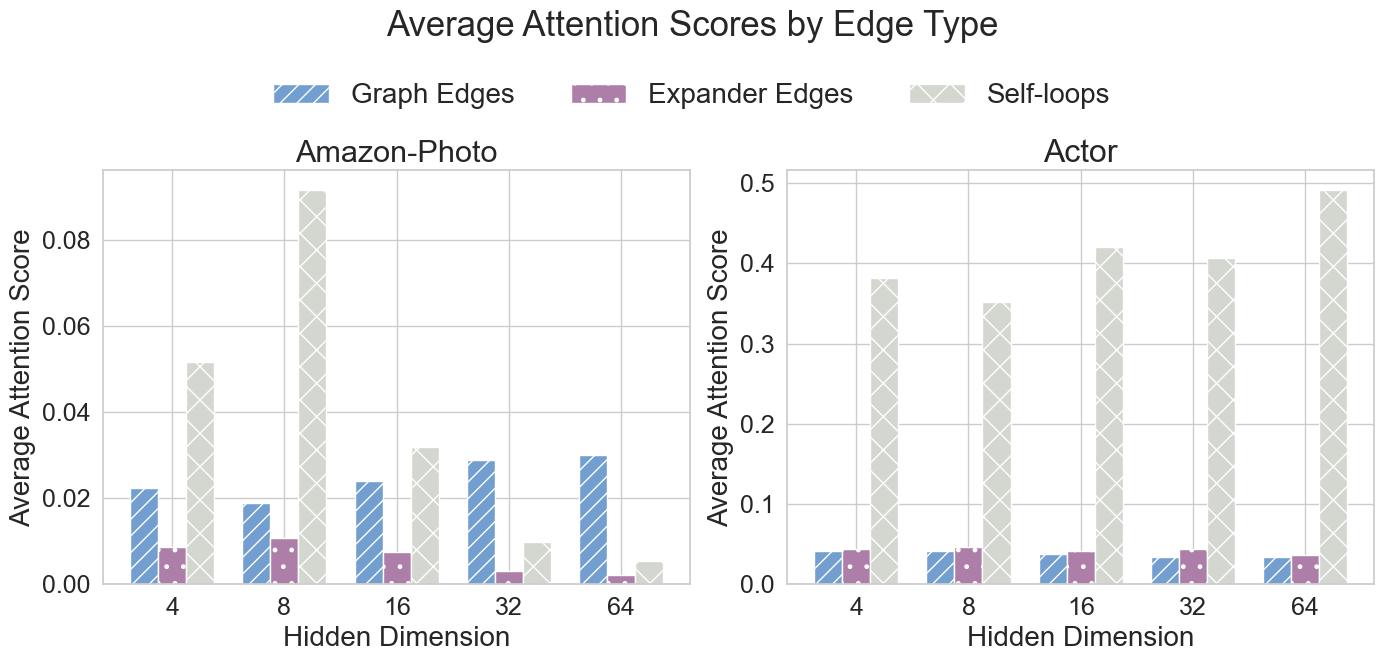

In [853]:
def plot_average_attention_by_edge_type(data1, data2, data_name1, data_name2, shared_title):
    """
    Plots two separate sets of data as barplots, side by side, each with its own y-axis, and a shared legend.

    Args:
        data1 (list): First list of numpy arrays, each with shape (3,).
        data2 (list): Second list of numpy arrays, each with shape (3,).
        data_name1 (str): Name for the first dataset.
        data_name2 (str): Name for the second dataset.
        shared_title (str): Title for the entire figure.
    """
    labels = ['Graph Edges', 'Expander Edges', 'Self-loops']
    patterns = ['//', '.', 'x']  # Patterns for the bars
    colors = ['#729fcf', '#ad7fa8', '#d3d7cf']

    # Transpose data for easier plotting
    data1 = np.array(data1).T
    data2 = np.array(data2).T

    width = 0.25  # Width of the bars
    x_labels = ['4', '8', '16', '32', '64']  # Hidden dimensions
    x = np.arange(len(x_labels))  # Numeric positions for the groups

    # Create the figure and subplots (no shared y-axis)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot the first dataset on the left
    for i in range(3):
        axes[0].bar(
            x + i * width, 
            data1[i], 
            width, 
            label=labels[i] if i == 0 else "",  # Add legend only once
            color = colors[i],
            hatch=patterns[i]
        )
    axes[0].set_title(data_name1, fontsize=22)
    axes[0].set_xlabel('Hidden Dimension', fontsize=20)
    axes[0].set_ylabel('Average Attention Score', fontsize=20)
    axes[0].set_xticks(x + width)  # Center ticks
    axes[0].set_xticklabels(x_labels, fontsize=18)
    axes[0].tick_params(axis='y', labelsize=18)

    # Plot the second dataset on the right
    for i in range(3):
        axes[1].bar(
            x + i * width, 
            data2[i], 
            width, 
            label=labels[i] if i == 0 else "",  # Add legend only once 
            color = colors[i],
            hatch=patterns[i]
        )
    axes[1].set_title(data_name2, fontsize=23)
    axes[1].set_xlabel('Hidden Dimension', fontsize=20)
    axes[1].set_ylabel('Average Attention Score', fontsize=20)
    axes[1].set_xticks(x + width)  # Center ticks
    axes[1].set_xticklabels(x_labels, fontsize=18)
    axes[1].tick_params(axis='y', labelsize=18)

    fig.legend(labels, fontsize=20, loc="upper center",bbox_to_anchor=(0.5, 1.02), ncol=3, frameon=False)

    # Add a shared title
    fig.suptitle(shared_title, y=1.1, fontsize=25)

    plt.tight_layout()
    plt.savefig(f'Figures/edge_type_normalized.pdf', bbox_inches='tight')
    plt.show()


plot_average_attention_by_edge_type(
    photo_normalized, 
    actor_normalized, 
    "Amazon-Photo", 
    "Actor", 
    "Average Attention Scores by Edge Type"
)
